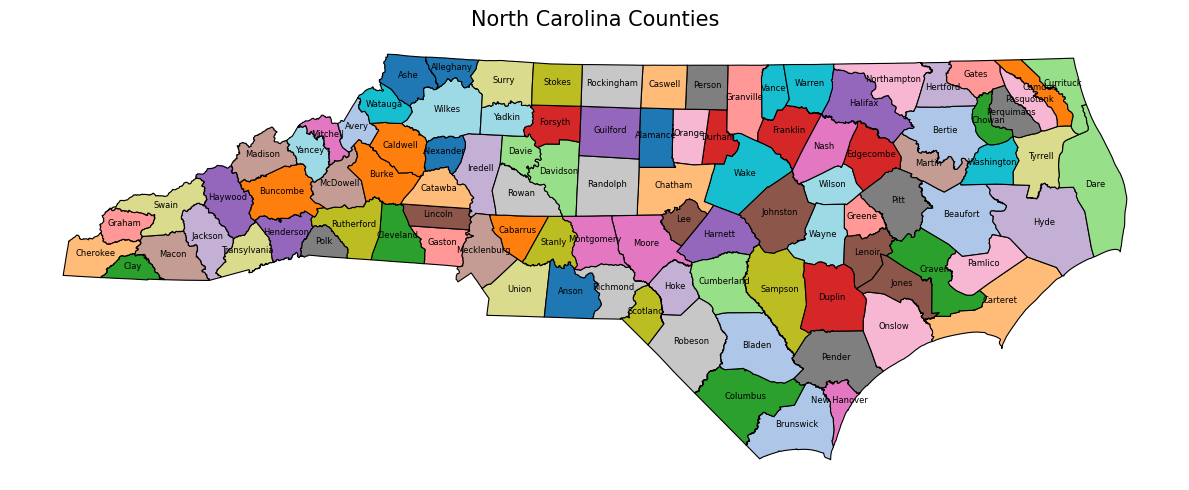

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

nc_counties = gpd.read_file('Boundaries/NCDOT_County_Boundaries.shp')

nc_counties['centroid'] = nc_counties.geometry.centroid

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nc_counties.plot(
    column='NAME',
    cmap='tab20',
    linewidth=0.8,
    ax=ax,
    edgecolor='black'
)

# Add county names
for _, row in nc_counties.iterrows():
    ax.annotate(
        text=row['NAME'],
        xy=(row['centroid'].x, row['centroid'].y),
        fontsize=6,
        ha='center',
        color='black'
    )

ax.set_title('North Carolina Counties', fontdict={'fontsize': '15', 'fontweight': '3'})

ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
file_path = 'Data/data.csv'  # Update with the actual path to your file
raw_data = pd.read_csv(file_path)

# Remove commas from numeric values
raw_data = raw_data.replace(",", "", regex=True)

# Transpose the dataset to make counties rows and dates columns
cleaned_data = raw_data.set_index("Date").T.reset_index()

# Rename the "index" column to "County" for clarity
cleaned_data.rename(columns={"index": "County"}, inplace=True)

# Convert numeric columns to proper numeric types
for col in cleaned_data.columns[1:]:
    cleaned_data[col] = pd.to_numeric(cleaned_data[col], errors='coerce')

cleaned_data.to_csv('Data/transposed_data.csv', index=False)


# Z-score normalization across rows (excluding the "County" column)
scaler = StandardScaler()
normalized_values = scaler.fit_transform(cleaned_data.iloc[:, 1:])

# Create a DataFrame for normalized data
normalized_data = pd.DataFrame(
    normalized_values,
    columns=cleaned_data.columns[1:],
    index=cleaned_data['County']
).reset_index()

normalized_data.to_csv('Data/transposed_normalized_data_zscore.csv', index=False)

normalized_values = MinMaxScaler().fit_transform(cleaned_data.iloc[:, 1:])  # Apply Min-Max scaling

# Create a DataFrame for normalized data
normalized_data = pd.DataFrame(
    normalized_values,
    columns=cleaned_data.columns[1:],
    index=cleaned_data['County']
).reset_index()

normalized_data.to_csv('Data/transposed_normalized_data_minmax.csv', index=False)

In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import os
from datetime import datetime

def select_dataset():
    print("Select the dataset to use:")
    print("1: Data/transposed_data.csv")
    print("2: Data/transposed_normalized_data.csv (Z-Score Normalized)")
    print("3: Data/transposed_normalized_data_minmax.csv (Min-Max Scaled)")
    
    choice = input("Enter 1, 2, or 3 for normal, z-score normalized, or min-max scaled: ").strip()
    if choice == "1":
        return "Data/transposed_data.csv"
    elif choice == "2":
        return "Data/transposed_normalized_data_zscore.csv"
    elif choice == "3":
        return "Data/transposed_normalized_data_minmax.csv"
    else:
        print("Invalid choice. Defaulting to Data/transposed_data.csv.")
        return "Data/transposed_data.csv"
    
# Ask user which years to include
def filter_years(data):
    include_2024 = input("Include 2024 data? (yes/no): ").strip().lower() == "yes"
    include_2023 = input("Include 2023 data? (yes/no): ").strip().lower() == "yes"
    include_2022 = input("Include 2022 data? (yes/no): ").strip().lower() == "yes"

    columns_to_keep = ["County"]
    if include_2024:
        columns_to_keep.extend([col for col in data.columns if col.startswith("2024")])
    if include_2023:
        columns_to_keep.extend([col for col in data.columns if col.startswith("2023")])
    if include_2022:
        columns_to_keep.extend([col for col in data.columns if col.startswith("2022")])

    return data[columns_to_keep]

def transform_to_quarters(data):
    # Extract year and month columns
    month_columns = [col for col in data.columns if col != 'County']
    years = sorted(set(col.split('-')[0] for col in month_columns))
    quarters = {'Q1': [1, 2, 3], 'Q2': [4, 5, 6], 'Q3': [7, 8, 9], 'Q4': [10, 11, 12]}

    # Ask user for each quarter
    include_quarters = {}
    for quarter, months in quarters.items():
        response = input(f"Should months {months} be averaged into {quarter}? (yes/no): ").strip().lower()
        include_quarters[quarter] = response == 'yes'

    # Initialize transformed dataset
    transformed_data = data.copy()

    # Process each year and quarter
    for year in years:
        for quarter, months in quarters.items():
            quarter_columns = [f"{year}-{str(month).zfill(2)}" for month in months if f"{year}-{str(month).zfill(2)}" in month_columns]

            if include_quarters[quarter]:
                # Calculate average and add as a new column
                if quarter_columns:
                    transformed_data[f"{year}-{quarter}"] = transformed_data[quarter_columns].mean(axis=1)
                
                # Remove original 3 monthly columns
                transformed_data.drop(columns=quarter_columns, inplace=True)
    
    return transformed_data

def filter_by_start_date(data):
    """
    Filters the dataset to include only columns from the specified start date onward.
    Default options: 'September 2024' or 'August 2024'.
    Allows the user to skip filtering by choosing 'No thanks'.
    
    Args:
        data (pd.DataFrame): The dataset containing columns with date information in 'YYYY-MM' format.
        
    Returns:
        pd.DataFrame: Filtered or unfiltered dataset based on user input.
    """
    print("Choose the start date for the data:")
    print("1: September 2024")
    print("2: August 2024")
    print("3: Enter custom start date (format: YYYY-MM)")
    print("4: No thanks, keep all data")
    choice = input("Only look at data starting from (1: September 2024, 2: August 2024, 3: Custom, 4: No thanks): ").strip()
    
    if choice == "1":
        start_date = "2024-09"
    elif choice == "2":
        start_date = "2024-08"
    elif choice == "3":
        custom_date = input("Enter your custom start date (format: YYYY-MM): ").strip()
        try:
            # Validate date format
            datetime.strptime(custom_date, "%Y-%m")
            start_date = custom_date
        except ValueError:
            print("Invalid date format. Defaulting to 'No thanks'.")
            return data
    elif choice == "4":
        print("Keeping all data.")
        return data
    else:
        print("Invalid choice. Keeping all data.")
        return data
    
    # Filter columns based on the start date
    date_columns = [col for col in data.columns if col != 'County']
    valid_columns = [col for col in date_columns if col >= start_date]
    
    # Ensure 'County' column is included
    columns_to_keep = ["County"] + valid_columns
    filtered_data = data[columns_to_keep]
    
    return filtered_data

def filter_to_september_october_november(data):
    """
    Filters the dataset to include only September, October, and November columns for each year if the user opts in.

    Args:
        data (pd.DataFrame): The dataset to filter.

    Returns:
        pd.DataFrame: The filtered dataset.
    """
    response = input("Keep only September, October, November, and December for each year? (yes/no): ").strip().lower()
    if response == "yes":
        # Identify columns for September, October, November
        months_to_keep = ["09", "10", "11", "12"]
        valid_columns = ["County"] + [col for col in data.columns if any(col.endswith(f"-{month}") for month in months_to_keep)]
        return data[valid_columns]
    elif response == "no":
        print("Keeping all months.")
        return data
    else:
        print("Invalid input. Keeping all months by default.")
        return data

def ratio_features(data):
    """
    Offers the user three options:
    1. Do nothing (retain all existing features).
    2. Add ratios for Aug-Dec (2024/2023) and remove other date-related features.
    3. Add ratios for all months (2023/2022) and remove other date-related features.

    Args:
        data (pd.DataFrame): The dataset to modify.

    Returns:
        pd.DataFrame: Modified dataset based on user selection.
    """
    print("Choose how to modify the dataset:")
    print("1: Do nothing, keep all existing features.")
    print("2: Add ratios for Aug-Dec (2024/2023) and remove others.")
    print("3: Add ratios for all months (2023/2022) and remove others.")
    choice = input("Enter your choice (1, 2, or 3) for (do nothing, ratios for Helene, ratios for YOT): ").strip()

    if choice == "1":
        print("No modifications applied to the dataset.")
        return data
    elif choice == "2":
        print("Adding ratios for Aug-Dec (2024/2023) and removing others.")

        # Define months for which ratios will be calculated
        months = [("08", "Aug"), ("09", "Sept"), ("10", "Oct"), ("11", "Nov"), ("12", "Dec")]

        # Add ratio features for 2024/2023
        for month, name in months:
            col_2024 = f"2024-{month}"
            col_2023 = f"2023-{month}"
            new_feature_name = f"2024_{name}/2023_{name}"
            if col_2024 in data.columns and col_2023 in data.columns:
                # Add the ratio column
                data[new_feature_name] = data[col_2024] / data[col_2023]

        # Retain only County and new ratio features
        ratio_features = [f"2024_{name}/2023_{name}" for _, name in months]
        ratio_features = ratio_features[::-1] # reverse order
        filtered_data = data[["County"] + ratio_features]

        print("Features modified successfully.")
        return filtered_data

    elif choice == "3":
        print("Adding ratios for all months (2023/2022) and removing others.")

        # Define months for which ratios will be calculated
        months = [f"{str(i).zfill(2)}" for i in range(1, 13)]

        # Add ratio features for 2023/2022
        for month in months:
            col_2023 = f"2023-{month}"
            col_2022 = f"2022-{month}"
            #col_2022 = f"2024-{month}"
            new_feature_name = f"23_{month}/22_{month}"
            if col_2023 in data.columns and col_2022 in data.columns:
                # Add the ratio column
                data[new_feature_name] = data[col_2023] / data[col_2022]

        # Retain only County and new ratio features
        ratio_features = [f"23_{month}/22_{month}" for month in months]
        filtered_data = data[["County"] + ratio_features]

        print("Features modified successfully.")
        return filtered_data

    else:
        print("Invalid choice. No modifications applied.")
        return data


# Load the selected dataset
data_path = select_dataset()
if os.path.exists(data_path):
    normalized_data = pd.read_csv(data_path)
else:
    raise FileNotFoundError(f"The file {data_path} does not exist.")

normalized_data = filter_years(normalized_data)

normalized_data = transform_to_quarters(normalized_data)

normalized_data = filter_by_start_date(normalized_data)

normalized_data = filter_to_september_october_november(normalized_data)

normalized_data = ratio_features(normalized_data)


Select the dataset to use:
1: Data/transposed_data.csv
2: Data/transposed_normalized_data.csv (Z-Score Normalized)
3: Data/transposed_normalized_data_minmax.csv (Min-Max Scaled)
Choose the start date for the data:
1: September 2024
2: August 2024
3: Enter custom start date (format: YYYY-MM)
4: No thanks, keep all data
Keeping all data.
Keeping all months.
Choose how to modify the dataset:
1: Do nothing, keep all existing features.
2: Add ratios for Aug-Dec (2024/2023) and remove others.
3: Add ratios for all months (2023/2022) and remove others.
Adding ratios for Aug-Dec (2024/2023) and removing others.
Features modified successfully.


In [6]:
print(normalized_data)

          County  2024_Dec/2023_Dec  2024_Nov/2023_Nov  2024_Oct/2023_Oct  \
0      Alexander           0.358974           1.626866           1.500000   
1      Alleghany           0.475000           0.535948           0.019608   
2           Ashe           0.170732           0.204188           0.031008   
3          Avery           0.155678           0.525411           0.076946   
4       Buncombe           0.218773           0.434794           0.111977   
5          Burke           0.150427           0.224891           0.081789   
6       Cabarrus           0.561224           1.215686           1.098901   
7       Caldwell           0.319149           0.602740           0.355705   
8        Catawba           0.600000           1.797297           1.546075   
9       Cherokee           0.310976           0.991071           0.937063   
10          Clay           0.525424           2.038961           0.898204   
11     Cleveland           0.355191           1.109114           0.075688   

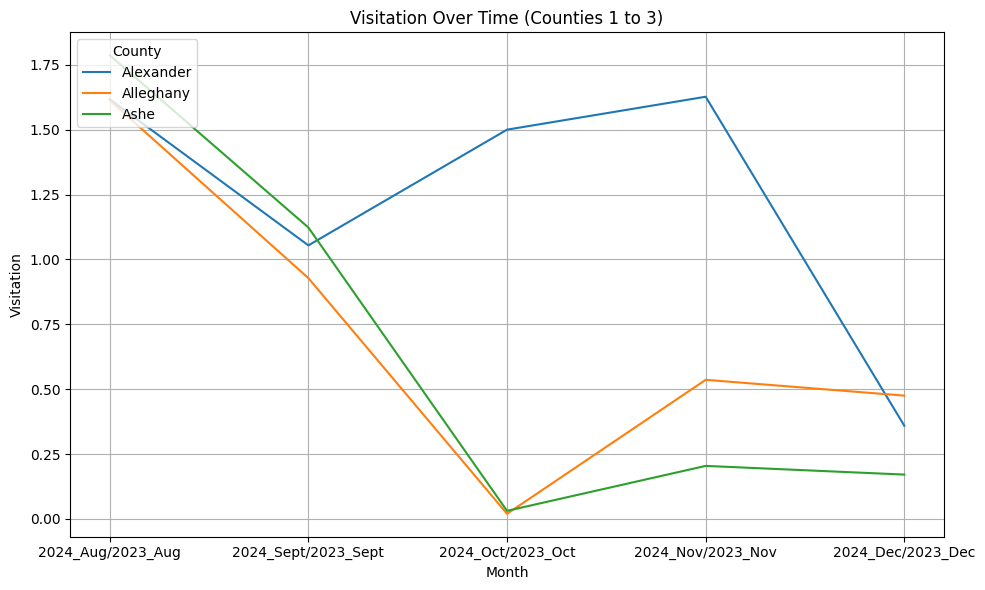

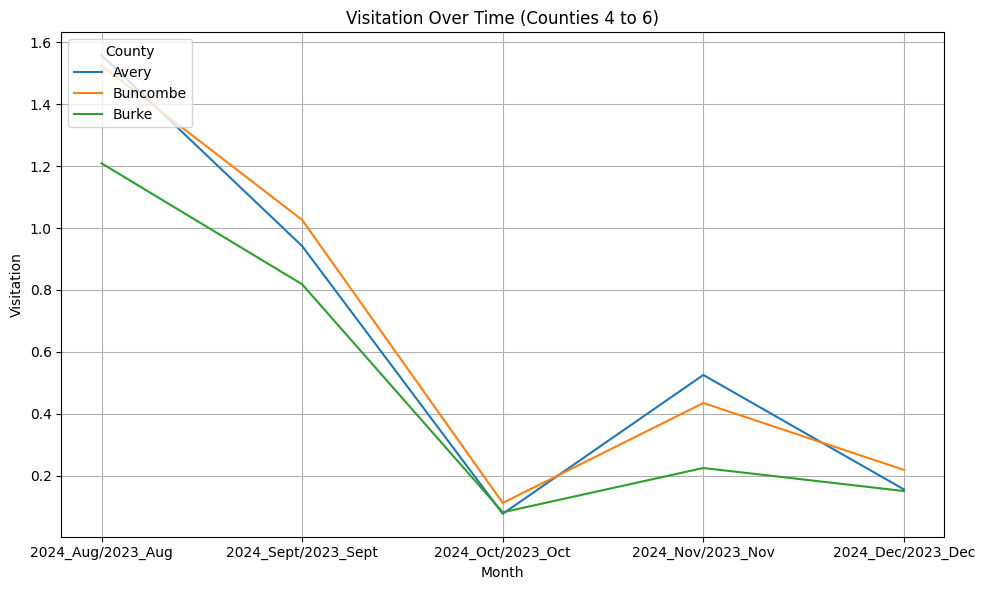

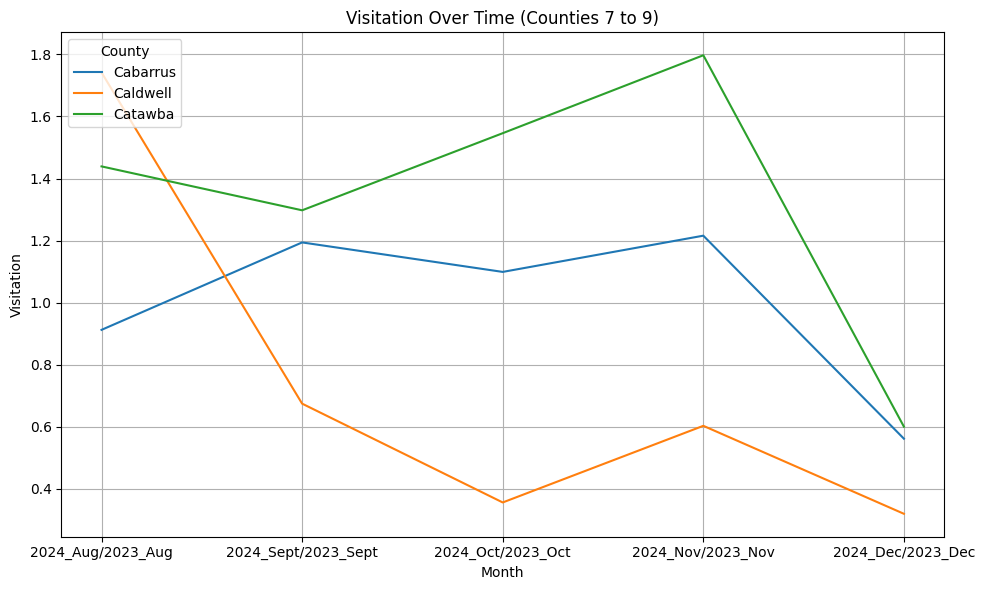

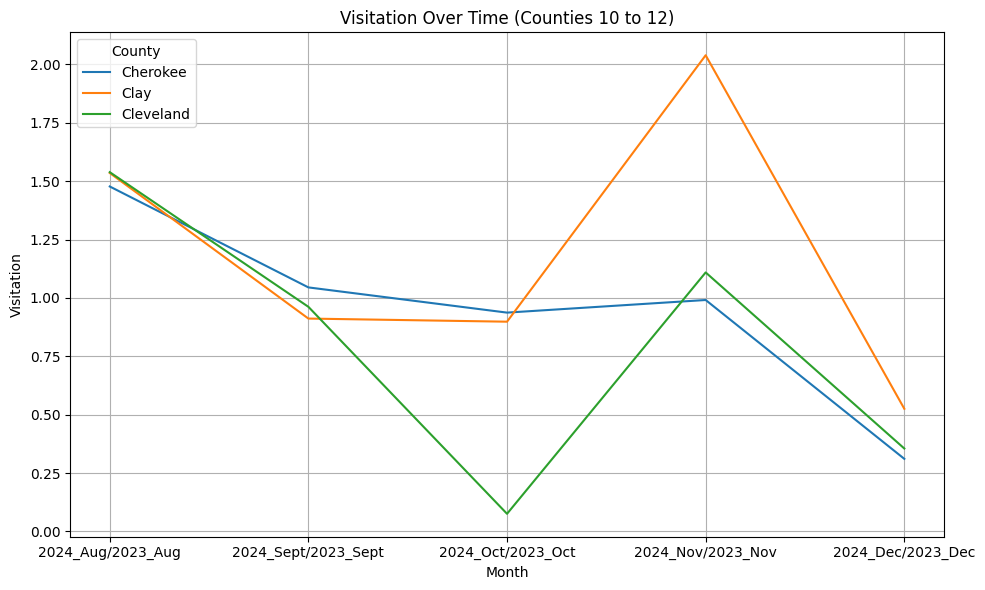

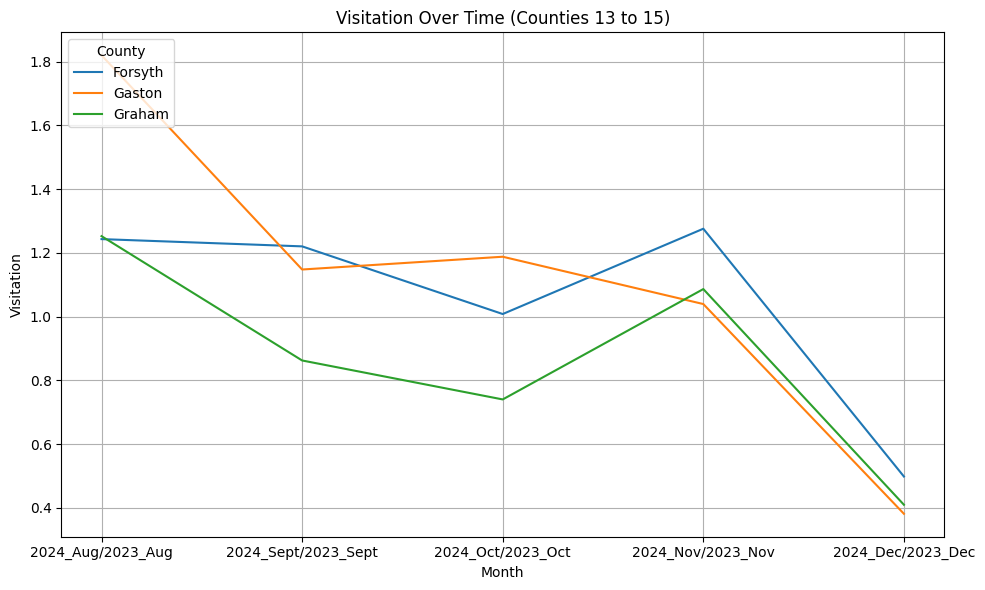

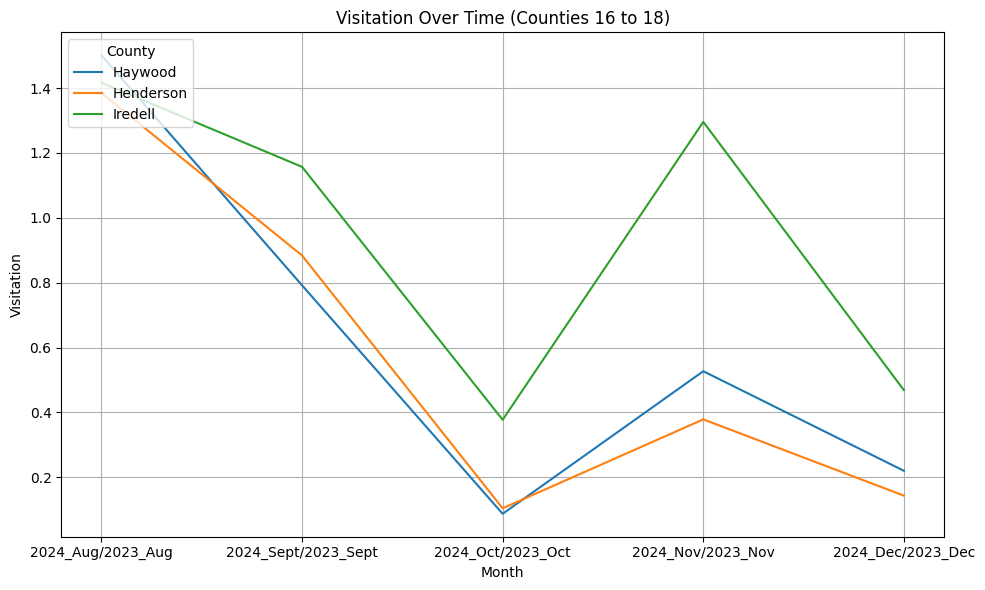

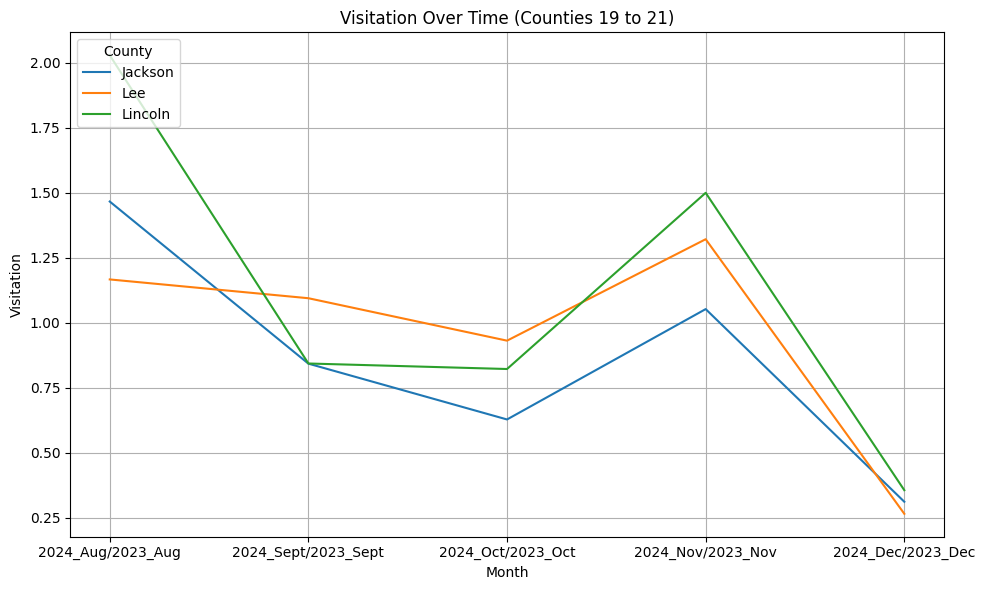

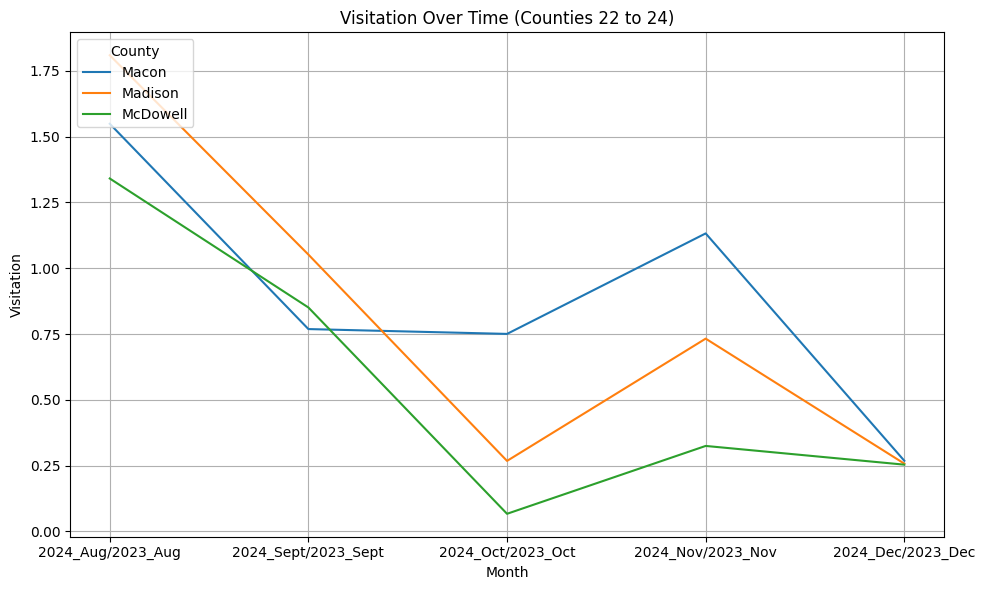

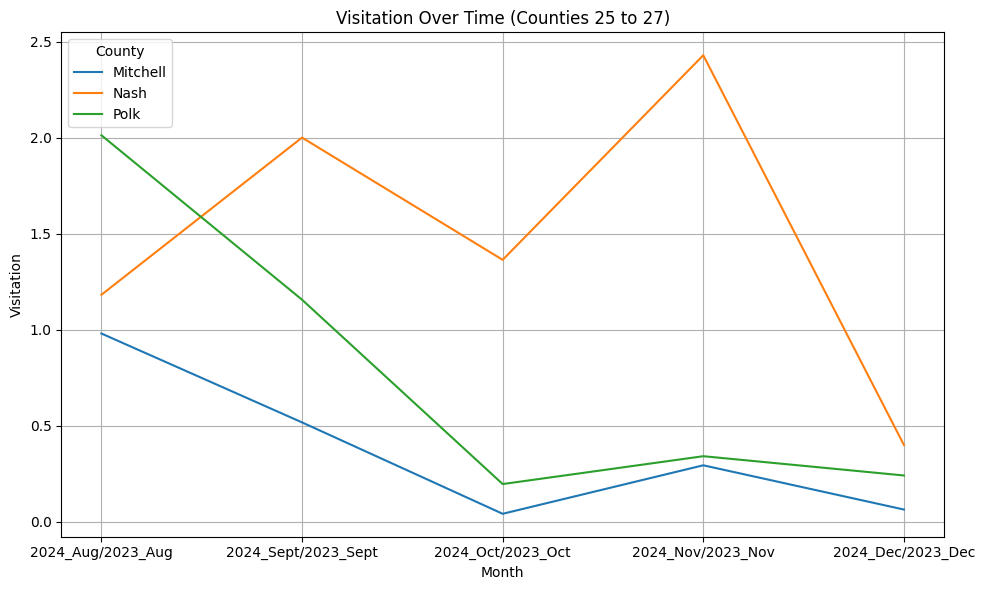

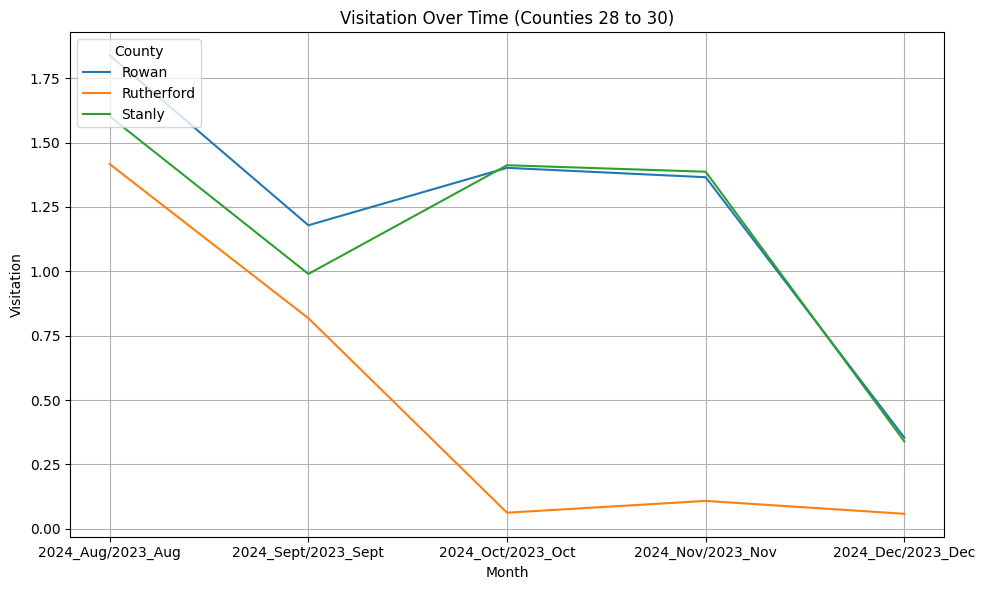

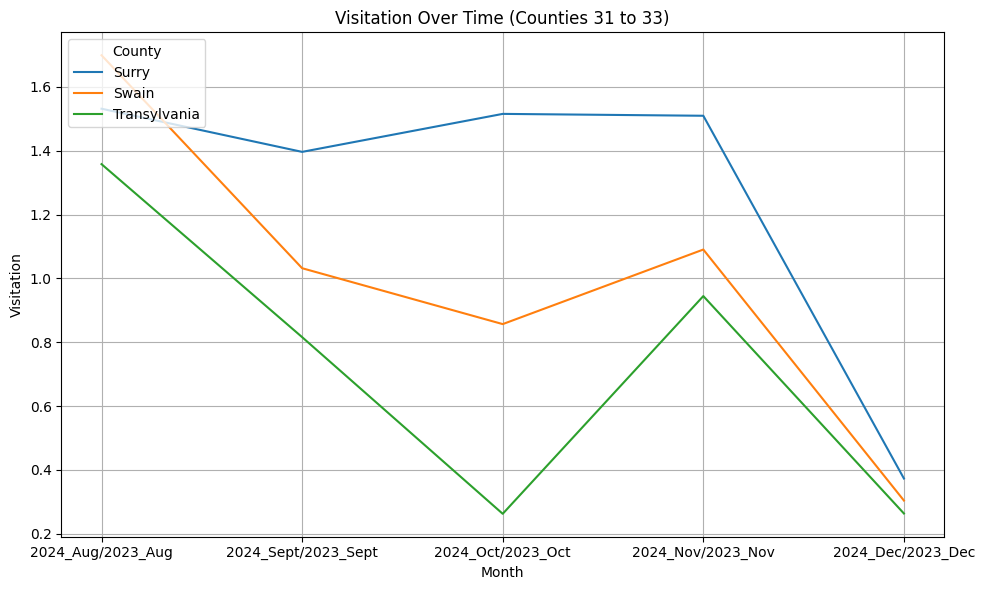

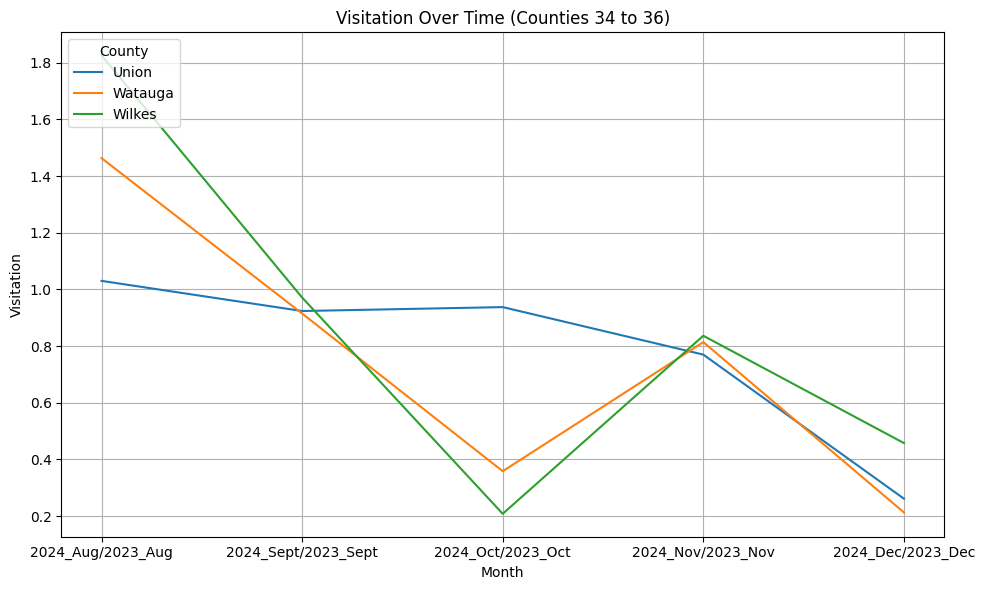

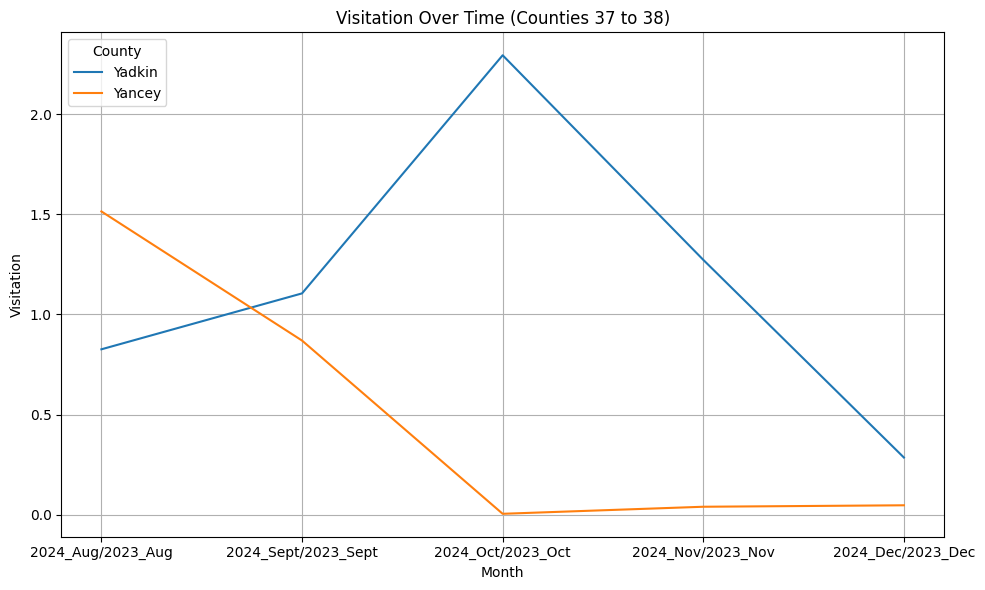

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Remove the County column and reverse the columns for plotting
reversed_data = normalized_data.set_index("County").iloc[:, ::-1]  # Set County as the index and reverse columns

# Plot visitation data
def plot_visitation(data, counties_per_plot=3):
    counties = data.index  # Get county names
    num_counties = len(counties)
    num_plots = (num_counties + counties_per_plot - 1) // counties_per_plot  # Calculate number of plots

    for i in range(num_plots):
        start_idx = i * counties_per_plot
        end_idx = min(start_idx + counties_per_plot, num_counties)
        selected_counties = counties[start_idx:end_idx]

        # Create a new figure for each plot
        plt.figure(figsize=(10, 6))
        for county in selected_counties:
            plt.plot(data.columns, data.loc[county], label=county)

        # Customize the plot
        plt.title(f"Visitation Over Time (Counties {start_idx+1} to {end_idx})")
        plt.xlabel("Month")
        plt.ylabel("Visitation")
        plt.legend(title="County", loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Call the function to plot visitation data
plot_visitation(reversed_data, counties_per_plot=3)


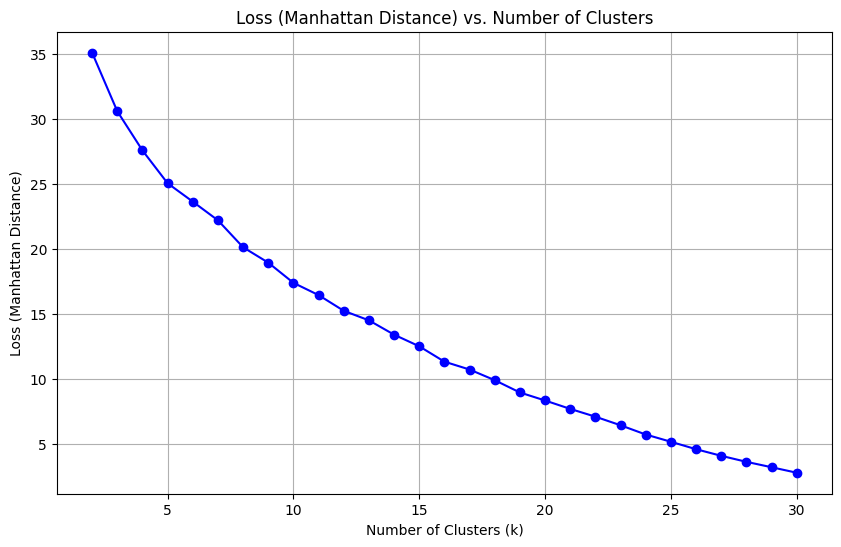

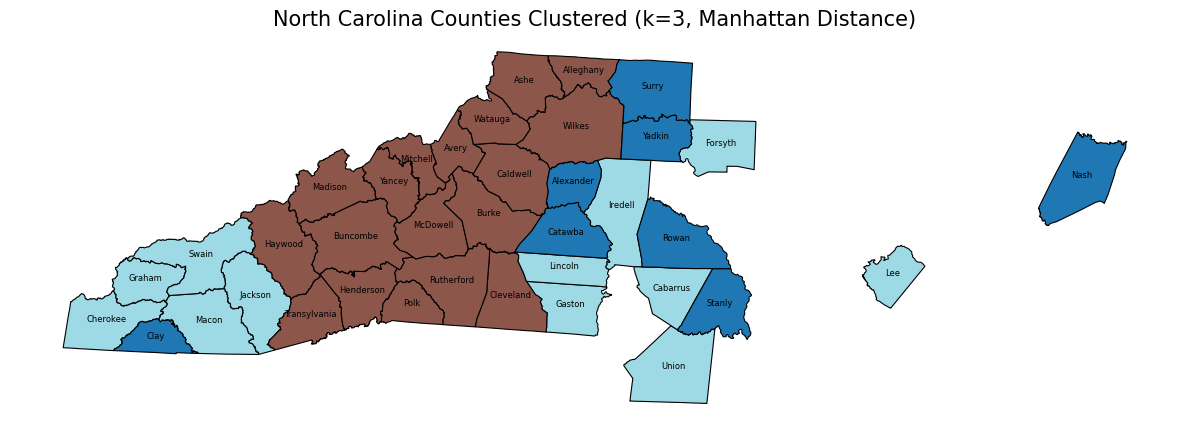

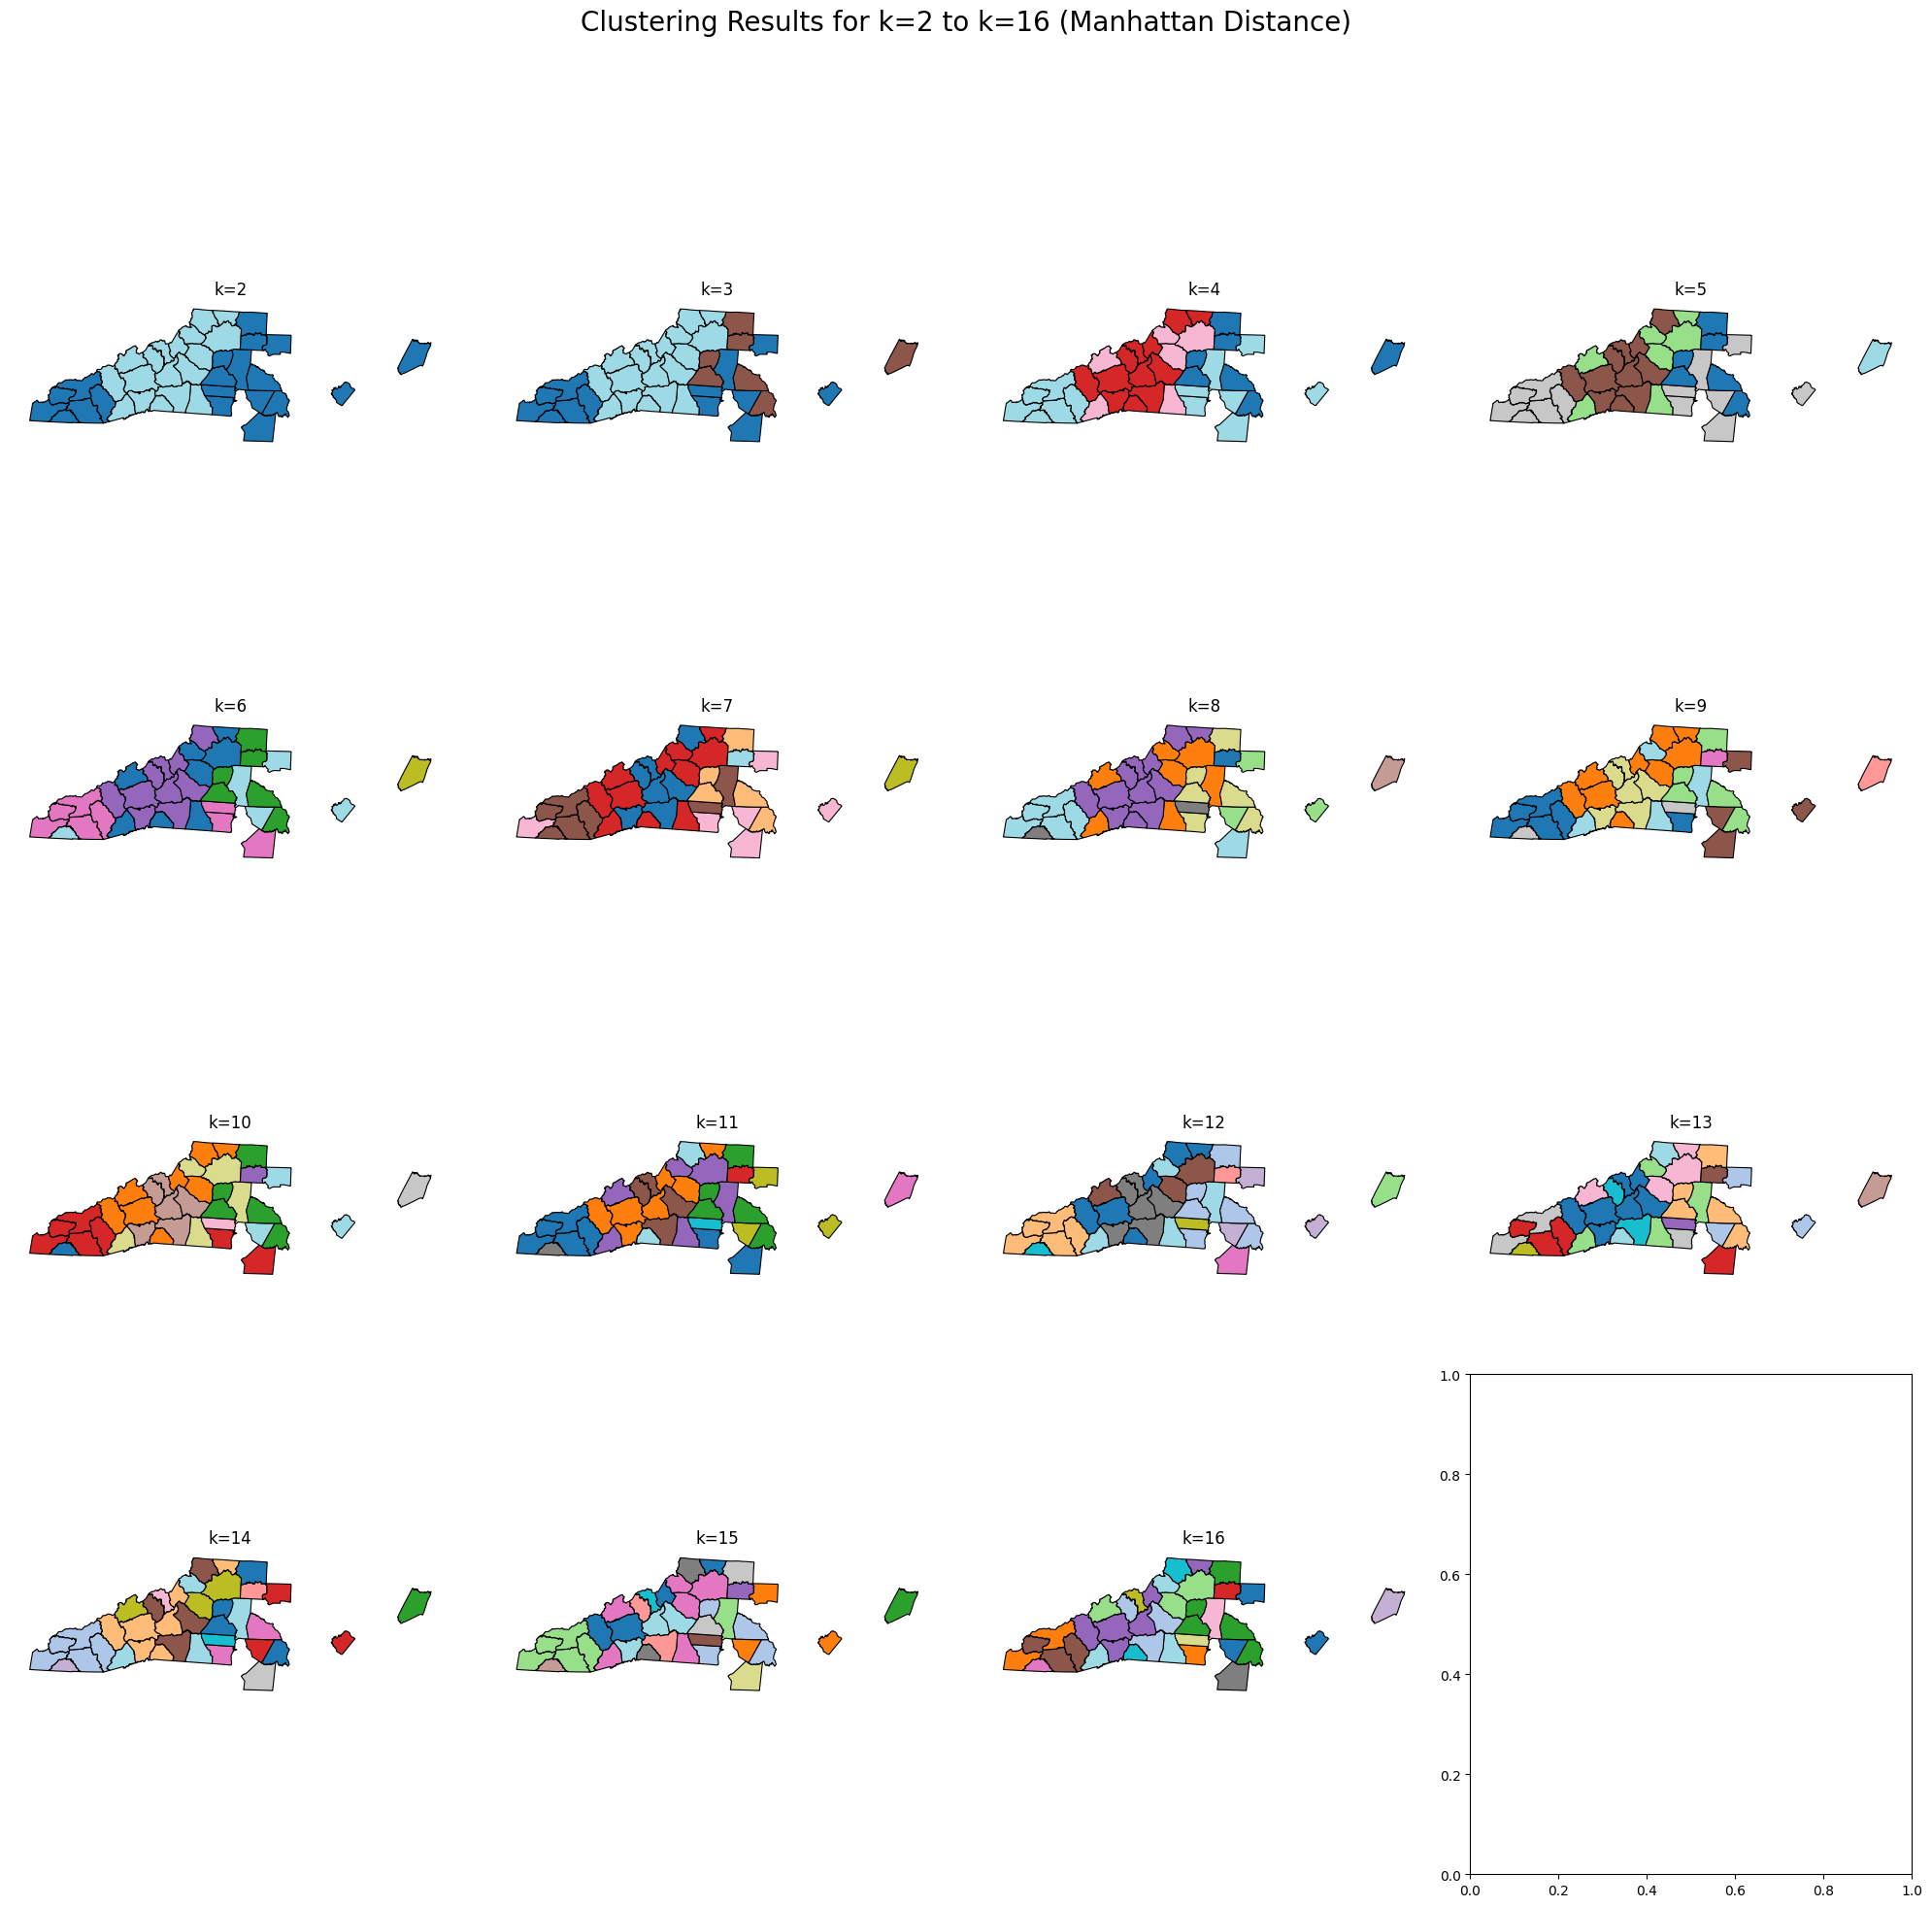

In [8]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import geopandas as gpd

# Assume normalized_data is already defined
# normalized_data = pd.read_csv('your_normalized_data.csv')  # Example

# Separate County column and normalized values
county_names = normalized_data['County']
normalized_values = normalized_data.drop(columns=['County']).values

# Ask user to choose distance metric
metric = input("Choose distance metric (manhattan, euclidean, cosine): ").strip().lower()

# Define a custom KMeans class if Manhattan is chosen
if metric == 'manhattan':
    class KMeansManhattan(KMeans):
        def fit(self, X, y=None):
            self._metric = 'cityblock'
            return super().fit(X, y)
    KMeansClass = KMeansManhattan
elif metric == 'euclidean':
    KMeansClass = KMeans
elif metric == 'cosine':
    # For cosine distance, normalize the data since cosine similarity is related to the angle between vectors
    normalized_values = normalized_values / np.linalg.norm(normalized_values, axis=1, keepdims=True)
    KMeansClass = KMeans
else:
    raise ValueError("Invalid metric chosen. Please choose from 'manhattan', 'euclidean', or 'cosine'.")

# Calculate loss (inertia) for k = 2 through k = 30, running KMeans 10 times for each k
k_values = range(2, 31)
inertia_values = []
best_kmeans_per_k = {}

for k in k_values:
    best_inertia = float('inf')
    best_kmeans = None
    for _ in range(10):  # Run KMeans 10 times
        kmeans = KMeansClass(n_clusters=k, random_state=np.random.randint(0, 1000)).fit(normalized_values)
        if metric == 'cosine':
            # Compute cosine distance inertia
            inertia = np.sum(np.min(cdist(normalized_values, kmeans.cluster_centers_, metric='cosine'), axis=1))
        elif metric == 'manhattan':
            inertia = np.sum(np.min(cdist(normalized_values, kmeans.cluster_centers_, metric='cityblock'), axis=1))
        else:  # Euclidean
            inertia = kmeans.inertia_
        
        if inertia < best_inertia:
            best_inertia = inertia
            best_kmeans = kmeans
    inertia_values.append(best_inertia)
    best_kmeans_per_k[k] = best_kmeans

# Plot loss (inertia) as a function of the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
plt.title(f"Loss ({metric.capitalize()} Distance) vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel(f"Loss ({metric.capitalize()} Distance)")
plt.grid(True)
plt.show()

# Ask user to pick k
k = int(input("Enter the number of clusters to visualize on the map (k): "))

# Run K-Means for the chosen k 10 times and pick the best
best_inertia = float('inf')
best_kmeans = None
for _ in range(10):
    kmeans = KMeansClass(n_clusters=k, random_state=np.random.randint(0, 1000)).fit(normalized_values)
    if metric == 'cosine':
        inertia = np.sum(np.min(cdist(normalized_values, kmeans.cluster_centers_, metric='cosine'), axis=1))
    elif metric == 'manhattan':
        inertia = np.sum(np.min(cdist(normalized_values, kmeans.cluster_centers_, metric='cityblock'), axis=1))
    else:  # Euclidean
        inertia = kmeans.inertia_
    
    if inertia < best_inertia:
        best_inertia = inertia
        best_kmeans = kmeans

# Assign clusters for the best KMeans
normalized_data['Cluster'] = best_kmeans.labels_

# Load geographic data for NC counties
nc_counties = gpd.read_file("Boundaries/NCDOT_County_Boundaries.shp")  # Update with the correct path
nc_counties['NAME'] = nc_counties['NAME'].str.strip()  # Ensure no trailing spaces in county names

# Merge cluster labels with geographic data
merged_data = nc_counties.merge(normalized_data, left_on='NAME', right_on='County')

# Plot the best clustering result for the chosen k
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
merged_data['centroid'] = merged_data.geometry.centroid
merged_data.plot(
    column='Cluster',
    cmap='tab20',
    linewidth=0.8,
    ax=ax,
    edgecolor='black'
)

# Add county names as annotations
for _, row in merged_data.iterrows():
    ax.annotate(
        text=row['NAME'],
        xy=(row['centroid'].x, row['centroid'].y),
        fontsize=6,
        ha='center',
        color='black'
    )

ax.set_title(f"North Carolina Counties Clustered (k={k}, {metric.capitalize()} Distance)", fontdict={'fontsize': '15', 'fontweight': '3'})
ax.axis('off')
plt.tight_layout()
plt.show()

# Subplot visualizations for k = 2 through 16
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle(f"Clustering Results for k=2 to k=16 ({metric.capitalize()} Distance)", fontsize=20)

for i, k in enumerate(range(2, 17)):
    ax = axes[i // 4, i % 4]
    kmeans = best_kmeans_per_k[k]
    
    if metric == 'cosine':
        # Compute cluster labels based on cosine distance
        labels = np.argmin(cdist(normalized_values, kmeans.cluster_centers_, metric='cosine'), axis=1)
    elif metric == 'manhattan':
        labels = np.argmin(cdist(normalized_values, kmeans.cluster_centers_, metric='cityblock'), axis=1)
    else:  # Euclidean
        labels = kmeans.labels_
    
    normalized_data['Cluster'] = labels
    merged_data = nc_counties.merge(normalized_data, left_on='NAME', right_on='County')
    merged_data['centroid'] = merged_data.geometry.centroid
    merged_data.plot(
        column='Cluster',
        cmap='tab20',
        linewidth=0.8,
        ax=ax,
        edgecolor='black'
    )
    ax.set_title(f"k={k}")
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust title position
plt.show()


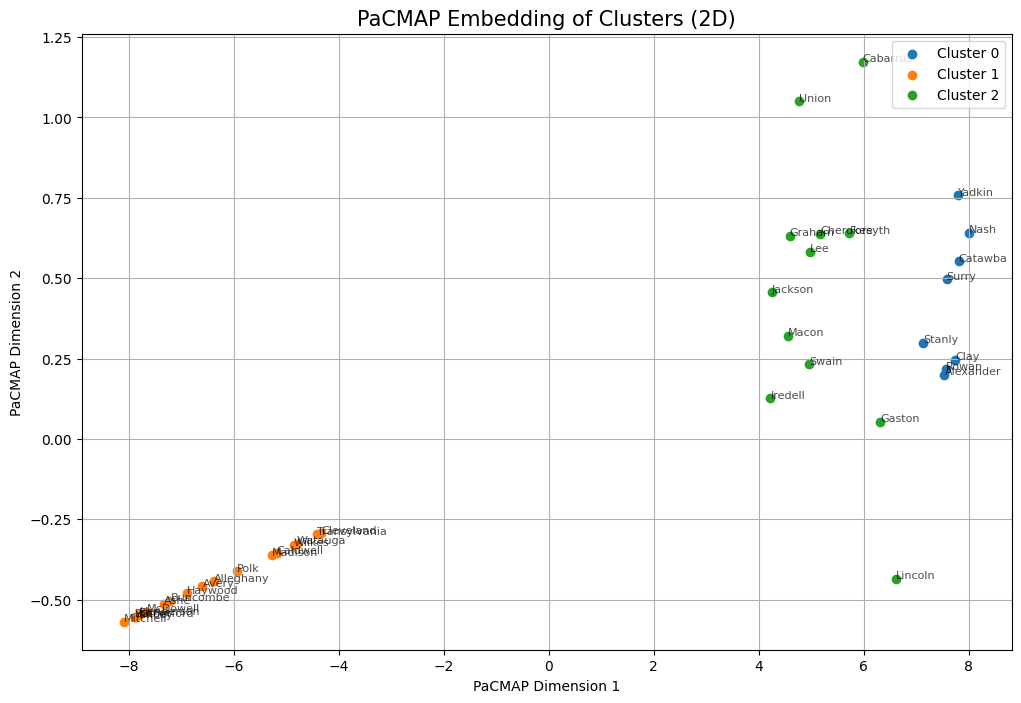

In [9]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import pacmap
from sklearn.decomposition import PCA
import plotly.express as px

normalized_data['Cluster'] = best_kmeans.labels_ # already added
county_names = normalized_data['County']

# Apply PaCMAP for dimensionality reduction
pacmap_reducer = pacmap.PaCMAP(n_components=2, random_state=42)
embedding_2d = pacmap_reducer.fit_transform(normalized_values)

# Plot 2D embeddings
plt.figure(figsize=(12, 8))
for cluster_label in np.unique(best_kmeans.labels_):
    cluster_points = embedding_2d[best_kmeans.labels_ == cluster_label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_label}")

for i, county_name in enumerate(county_names):
    plt.text(embedding_2d[i, 0], embedding_2d[i, 1], county_name, fontsize=8, alpha=0.7)

plt.title("PaCMAP Embedding of Clusters (2D)", fontsize=15)
plt.xlabel("PaCMAP Dimension 1")
plt.ylabel("PaCMAP Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

interactive_df = pd.DataFrame({
    'PaCMAP Dimension 1': embedding_2d[:, 0],
    'PaCMAP Dimension 2': embedding_2d[:, 1],
    'Cluster': best_kmeans.labels_,
    'County Name': county_names
})

interactive_df['Cluster'] = interactive_df['Cluster'].astype(str)

# Create an interactive scatter plot using Plotly
fig = px.scatter(
    interactive_df,
    x='PaCMAP Dimension 1',
    y='PaCMAP Dimension 2',
    color='Cluster',  # Clusters as discrete categories
    hover_data=['County Name'],
    title='PaCMAP Embedding of Clusters (2D)'
)

# Update layout to make the plot cleaner and remove colorbar gradient
fig.update_layout(
    xaxis_title="PaCMAP Dimension 1",
    yaxis_title="PaCMAP Dimension 2",
    legend_title="Cluster",
    template="plotly_white",
    coloraxis_showscale=False  # Disable the color scale
)

# Show the interactive plot
fig.show()

[[ 1.          0.72868852  0.51387842  0.45514632  0.03329103]
 [ 0.72868852  1.          0.76871815  0.60756048 -0.07233981]
 [ 0.51387842  0.76871815  1.          0.53222038 -0.2189349 ]
 [ 0.45514632  0.60756048  0.53222038  1.         -0.03786864]
 [ 0.03329103 -0.07233981 -0.2189349  -0.03786864  1.        ]]


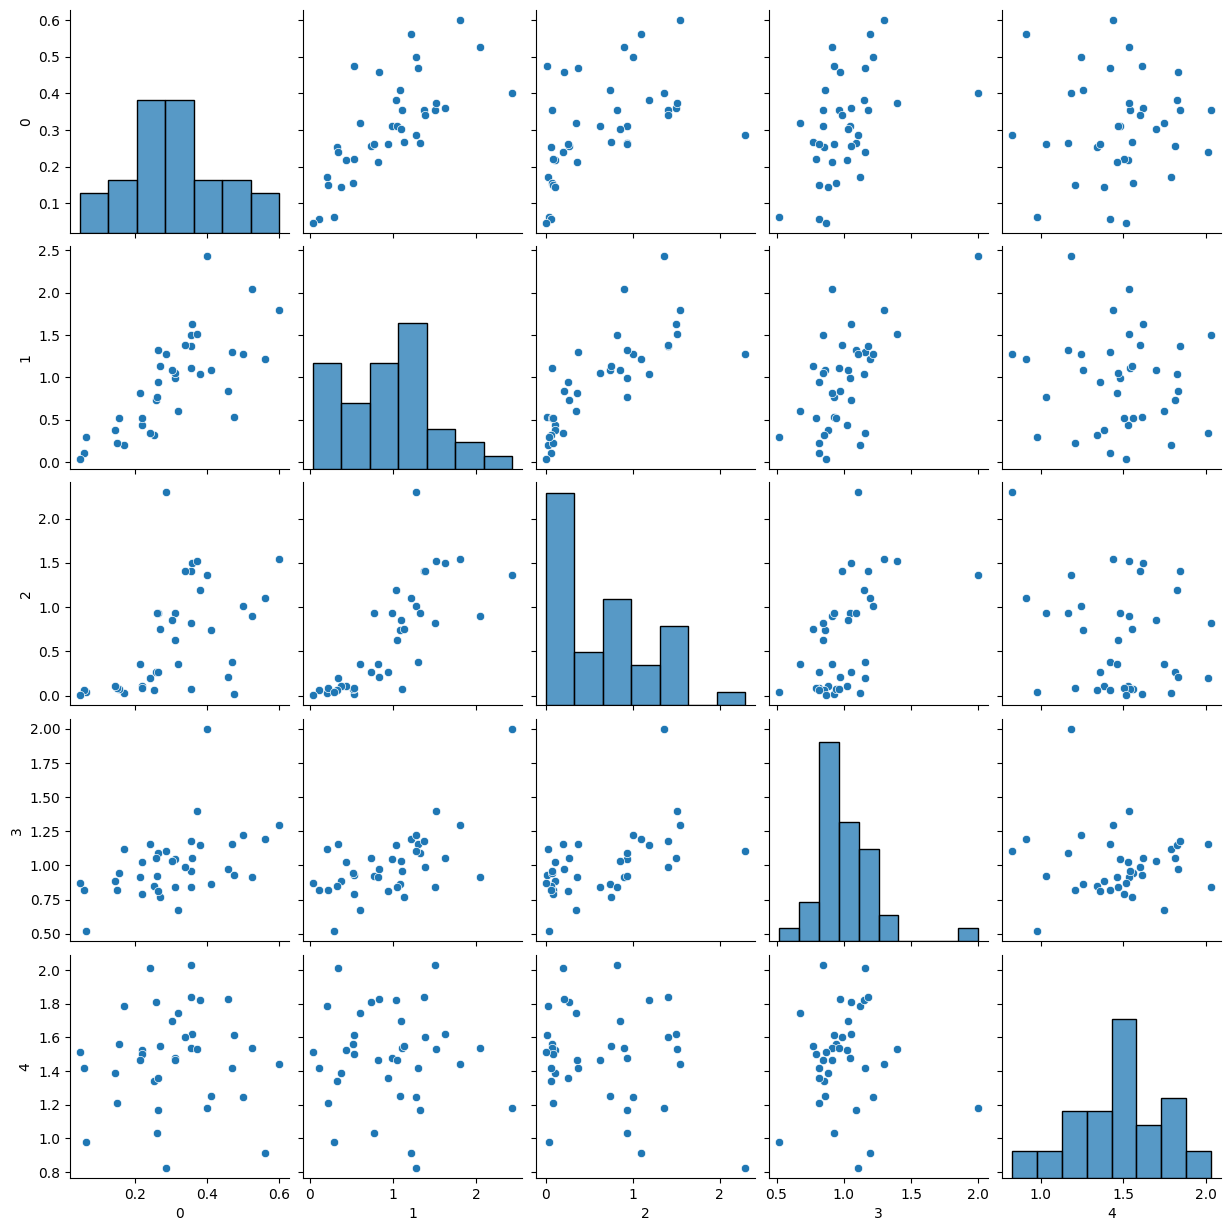

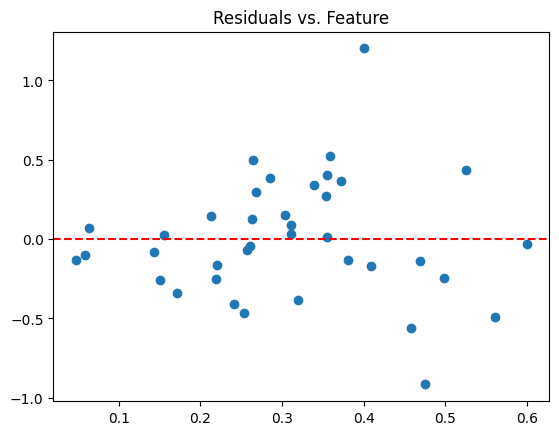

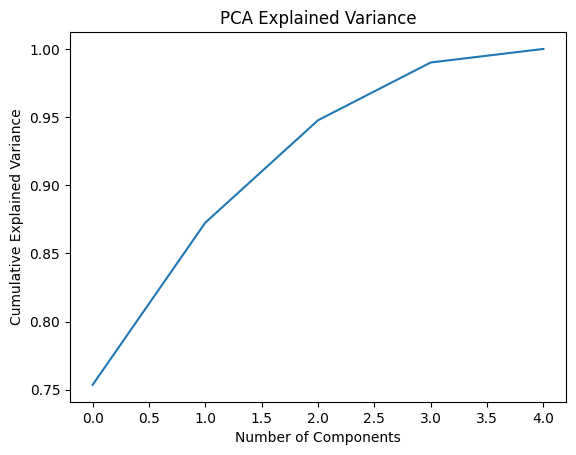

AttributeError: 'KernelPCA' object has no attribute 'lambdas_'

In [20]:
correlation_matrix = np.corrcoef(normalized_values.T)
print(correlation_matrix)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(normalized_values)
sns.pairplot(df)
plt.show()

from sklearn.linear_model import LinearRegression

X, y = normalized_values[:, 0], normalized_values[:, 1]
model = LinearRegression().fit(X.reshape(-1, 1), y)
residuals = y - model.predict(X.reshape(-1, 1))
plt.scatter(X, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Feature")
plt.show()

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(normalized_values)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()




Sorted Counties by 1D PCA Embedding:
          County    PCA_1D
37        Yancey -1.120059
28    Rutherford -1.036417
24      Mitchell -0.959591
2           Ashe -0.945467
5          Burke -0.921819
23      McDowell -0.856505
16     Henderson -0.802888
26          Polk -0.736671
15       Haywood -0.733360
4       Buncombe -0.732082
1      Alleghany -0.726221
3          Avery -0.722985
7       Caldwell -0.520143
22       Madison -0.432776
35        Wilkes -0.400363
34       Watauga -0.324853
32  Transylvania -0.313498
11     Cleveland -0.308499
18       Jackson  0.021281
17       Iredell  0.089005
33         Union  0.091699
21         Macon  0.136407
14        Graham  0.152555
31         Swain  0.230870
9       Cherokee  0.239536
20       Lincoln  0.425191
13        Gaston  0.456392
19           Lee  0.478693
12       Forsyth  0.550359
6       Cabarrus  0.597764
29        Stanly  0.823579
27         Rowan  0.826350
10          Clay  0.901493
0      Alexander  1.058967
30         Surry  

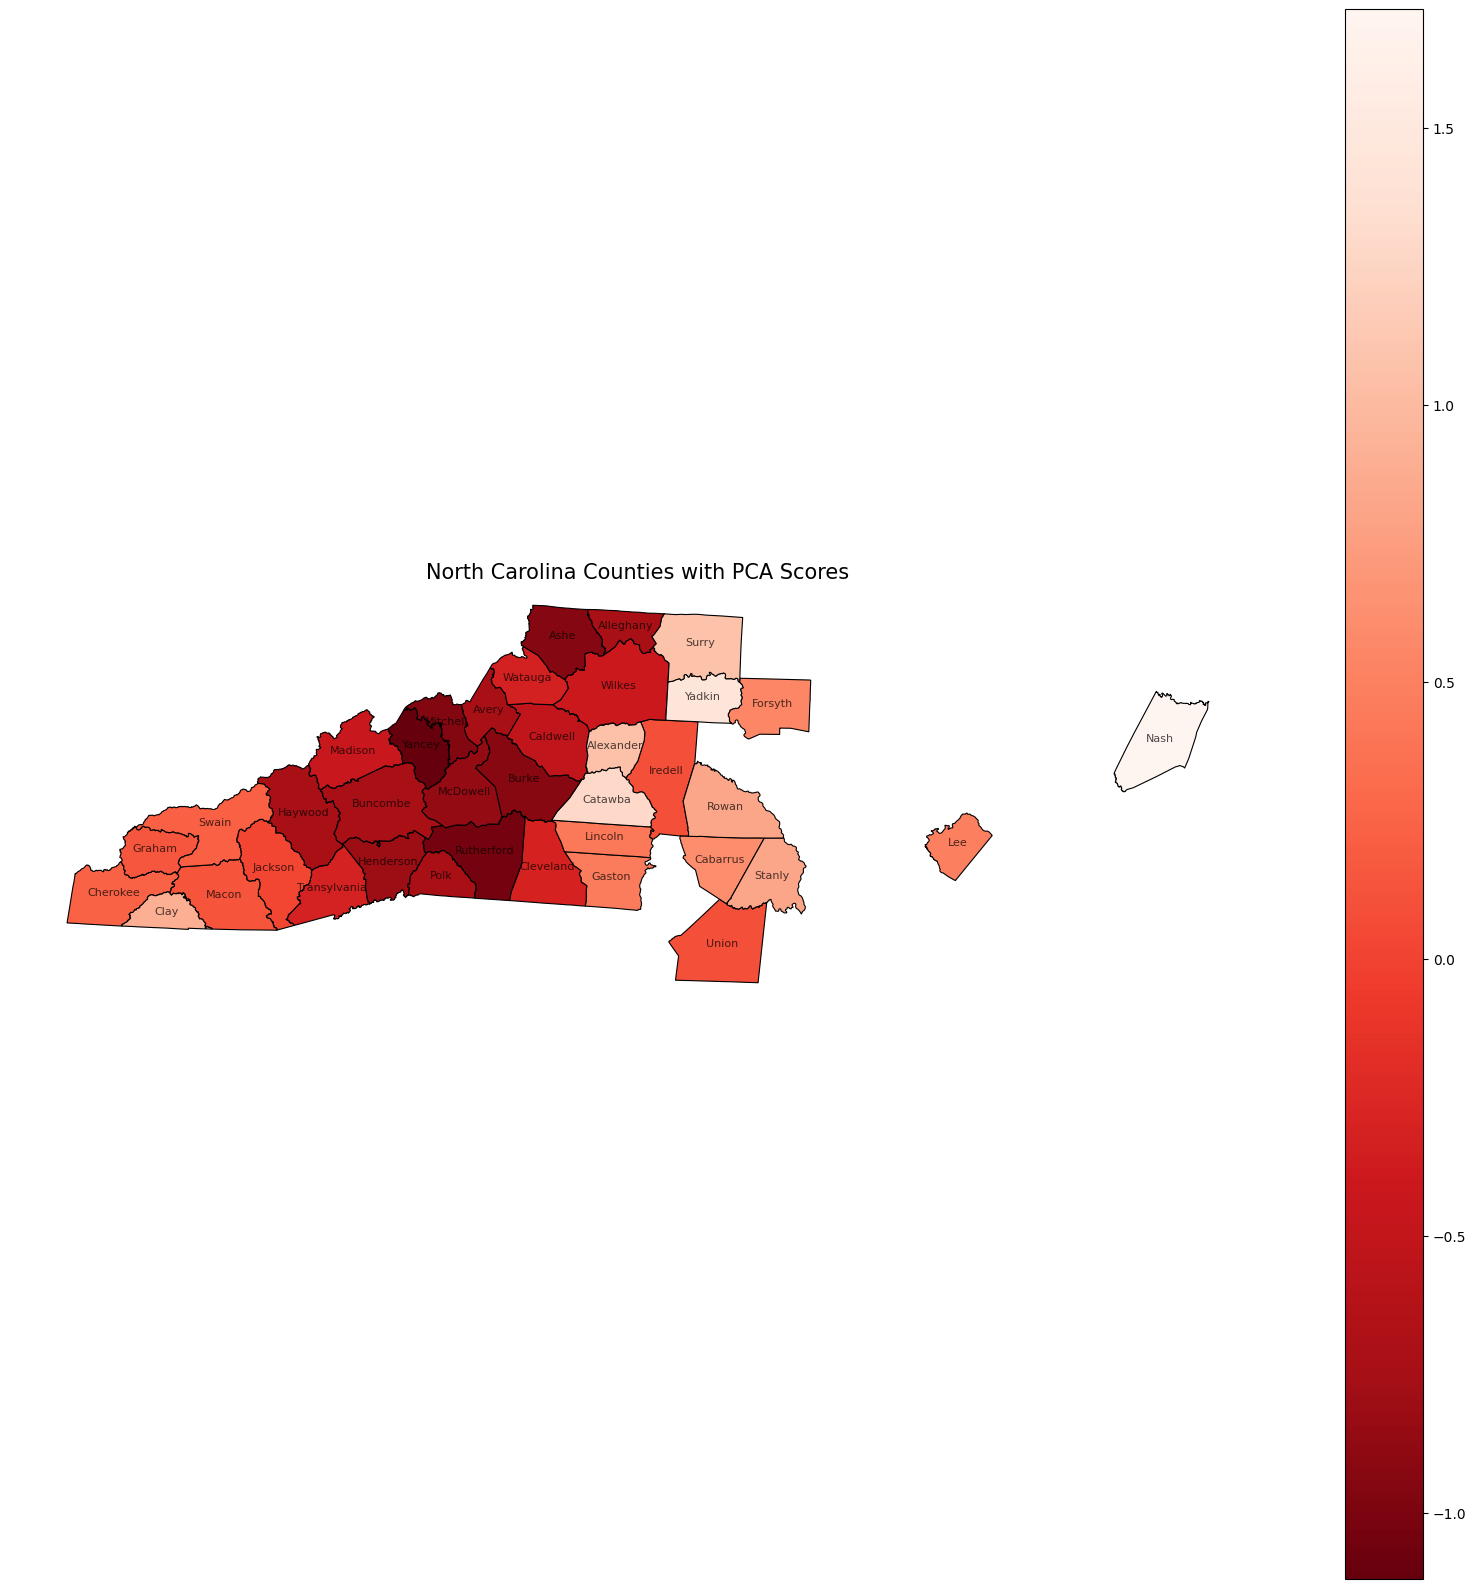

In [10]:
# Apply PCA for 1D embedding
pca_reducer = PCA(n_components=1)
embedding_1d = pca_reducer.fit_transform(normalized_values)

# Create a sorted table of counties by their 1D PCA embedding values
sorted_table = pd.DataFrame({
    'County': county_names,
    'PCA_1D': embedding_1d.flatten()
}).sort_values(by='PCA_1D')

print("Sorted Counties by 1D PCA Embedding:")
print(sorted_table)


# Load geographic data for NC counties
nc_counties = gpd.read_file("Boundaries/NCDOT_County_Boundaries.shp")  # Update with the correct path
nc_counties['NAME'] = nc_counties['NAME'].str.strip()  # Ensure no trailing spaces in county names

# Merge cluster labels and PCA scores with geographic data
normalized_data['PCA_1D'] = embedding_1d.flatten()
merged_data = nc_counties.merge(normalized_data, left_on='NAME', right_on='County')

# Determine Buncombe's PCA value
buncombe_pca_value = merged_data.loc[merged_data['NAME'] == 'Buncombe', 'PCA_1D'].values[0]

# Check whether to flip the colormap
cmap = 'Reds'
if buncombe_pca_value < np.median(merged_data['PCA_1D']):
    cmap = cmap + '_r'  # Reverse the colormap if Buncombe is below the median

# Plot counties colored by PCA score
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
merged_data.plot(
    column='PCA_1D',
    cmap=cmap,
    linewidth=0.8,
    ax=ax,
    edgecolor='black',
    legend=True
)

# Add county labels without scores
for x, y, label in zip(merged_data.geometry.centroid.x, merged_data.geometry.centroid.y, merged_data['NAME']):
    ax.text(x, y, label, fontsize=8, ha='center', alpha=0.7)

ax.set_title("North Carolina Counties with PCA Scores", fontdict={'fontsize': '15', 'fontweight': '3'})
ax.axis('off')
plt.tight_layout()
plt.show()

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Sorted Counties by 1D UMAP Embedding:
          County    UMAP_1D
0         Yadkin  11.113523
1          Surry  11.301997
2           Nash  11.648711
3        Catawba  11.702236
4      Alexander  12.113223
5           Clay  12.212907
6       Cabarrus  12.642146
7          Rowan  12.687407
8         Stanly  12.872061
9        Forsyth  12.993356
10           Lee  13.209047
11       Lincoln  13.577049
12        Gaston  13.755331
13      Cherokee  14.007927
14         Union  14.293194
15         Swain  14.391626
16         Macon  14.740398
17        Graham  14.802908
18       Jackson  15.239014
19       Iredell  15.756121
20     Cleveland  16.399384
21  Transylvania  16.551241
22       Watauga  16.902723
23        Wilkes  17.327881
24       Madison  17.559361
25      Caldwell  17.796843
26     Alleghany  18.271450
27       Haywood  18.447269
28         Avery  18.765299
29      Buncombe  18.843845
30          Ashe  19.047821
31          Polk  19.113575
32      McDowell  19.649231
33        

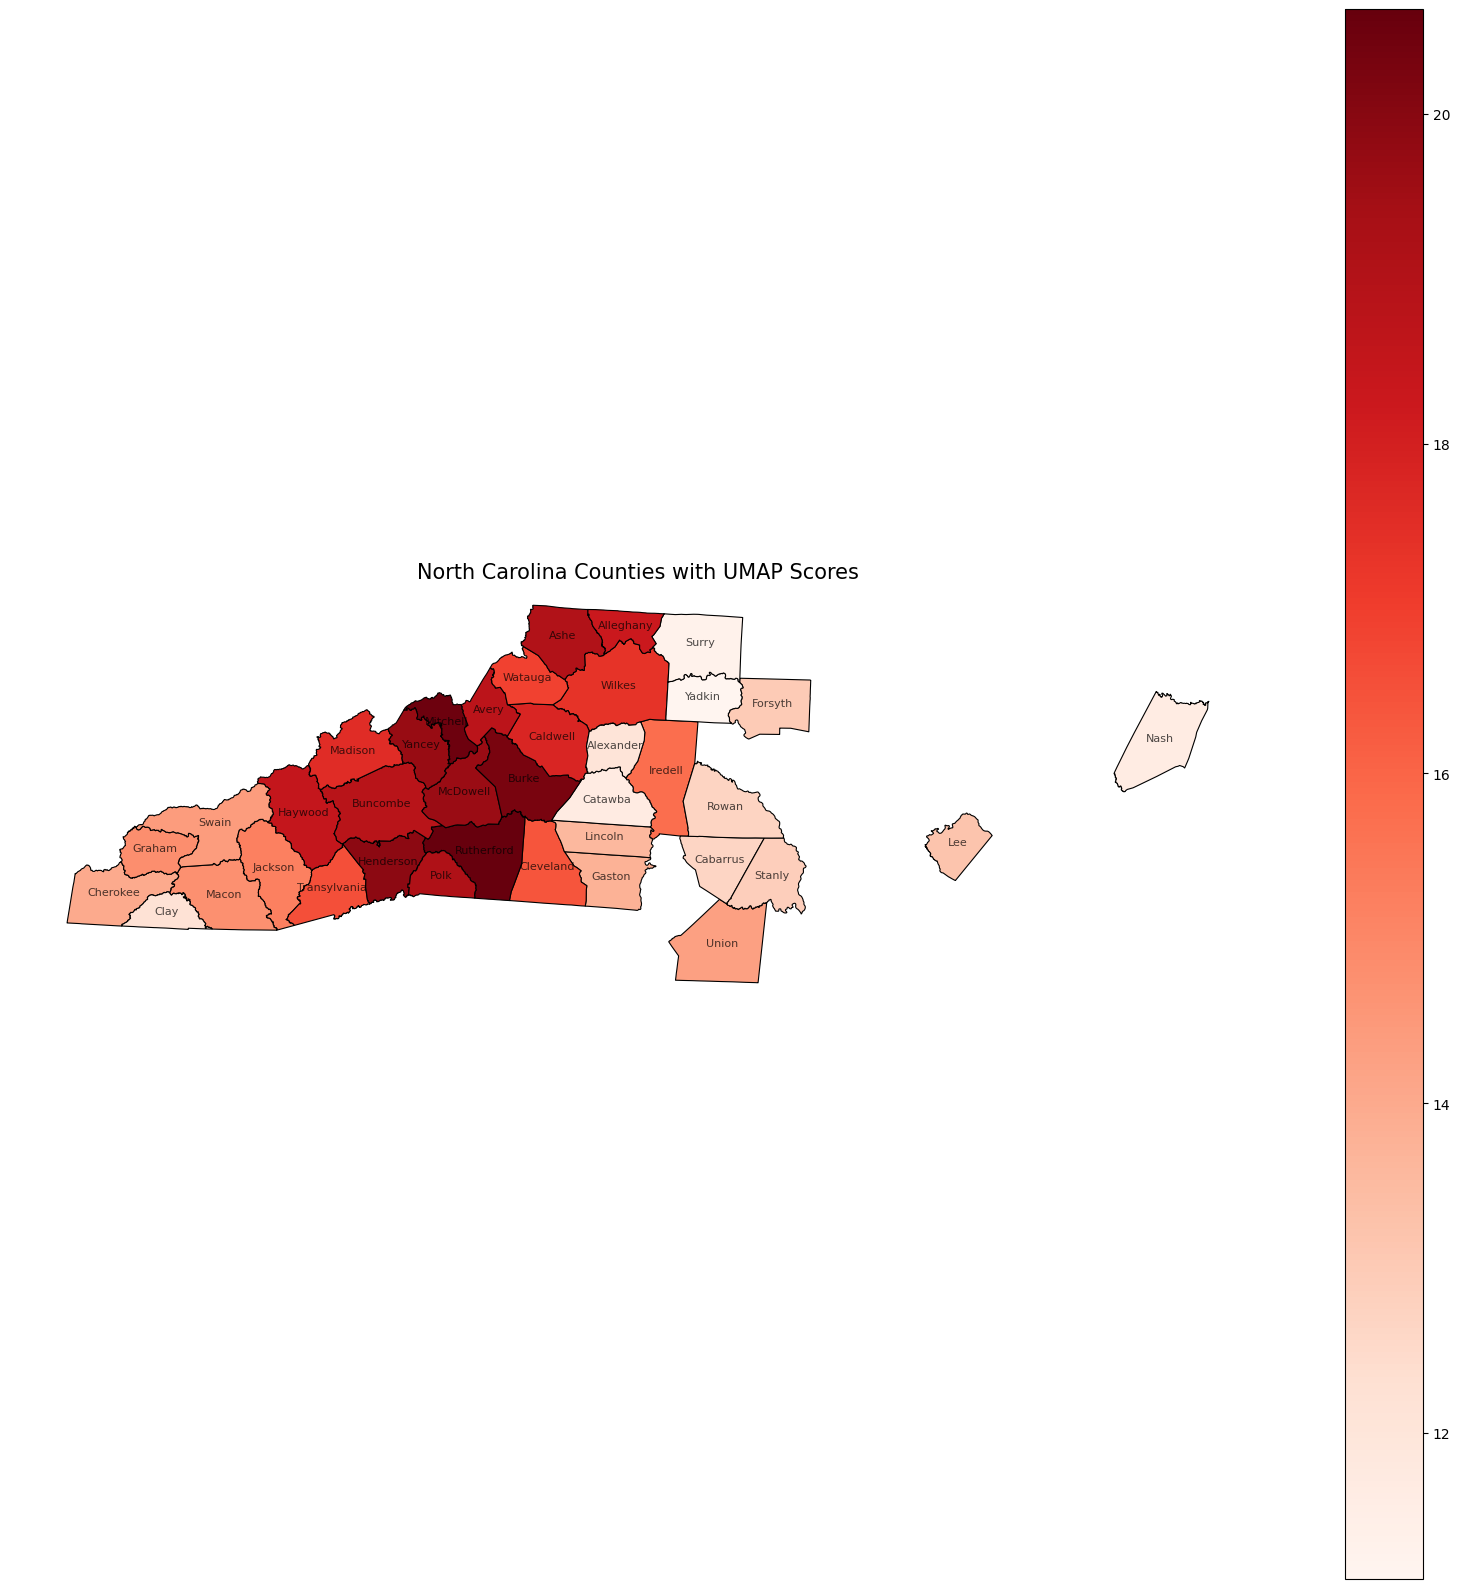

In [11]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import umap.umap_ as umap  # Import UMAP

# UMAP for 1D embedding
umap_reducer = umap.UMAP(n_components=1, random_state=42)
embedding_1d = umap_reducer.fit_transform(normalized_values)

# Create a sorted table of counties by their 1D UMAP embedding values
sorted_table = pd.DataFrame({
    'County': county_names,
    'UMAP_1D': embedding_1d.flatten()
}).sort_values(by='UMAP_1D').reset_index(drop=True)

print("Sorted Counties by 1D UMAP Embedding:")
print(sorted_table)

# Load geographic data for NC counties
nc_counties = gpd.read_file("Boundaries/NCDOT_County_Boundaries.shp")
nc_counties['NAME'] = nc_counties['NAME'].str.strip()

# Merge cluster labels and UMAP scores with geographic data
normalized_data['UMAP_1D'] = embedding_1d.flatten()
merged_data = nc_counties.merge(normalized_data, left_on='NAME', right_on='County')

# Determine Buncombe's UMAP value
buncombe_umap_value = merged_data.loc[merged_data['NAME'] == 'Buncombe', 'UMAP_1D'].values[0]

# Check whether to flip the colormap
cmap = 'Reds'
if buncombe_umap_value < np.median(merged_data['UMAP_1D']):
    cmap = cmap + '_r'  # Reverse the colormap if Buncombe is below the median

# Plot counties colored by UMAP score
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
merged_data.plot(
    column='UMAP_1D',
    cmap=cmap,
    linewidth=0.8,
    ax=ax,
    edgecolor='black',
    legend=True
)

# Add county labels without scores
for x, y, label in zip(merged_data.geometry.centroid.x, merged_data.geometry.centroid.y, merged_data['NAME']):
    ax.text(x, y, label, fontsize=8, ha='center', alpha=0.7)

ax.set_title("North Carolina Counties with UMAP Scores", fontdict={'fontsize': '15', 'fontweight': '3'})
ax.axis('off')
plt.tight_layout()
plt.show()


Sorted Counties by 1D t-SNE Embedding:
          County   tSNE_1D
0       Mitchell  4.464501
1         Yancey  4.511775
2     Rutherford  4.564424
3          Burke  4.638173
4           Ashe  4.652724
5       McDowell  4.790566
6           Polk  4.798963
7      Henderson  4.828188
8       Buncombe  4.922515
9          Avery  4.968037
10       Haywood  4.972553
11     Alleghany  4.974976
12      Caldwell  5.204684
13       Madison  5.272745
14        Wilkes  5.329233
15       Watauga  5.433824
16     Cleveland  5.455500
17  Transylvania  5.466650
18       Iredell  5.886970
19       Jackson  5.892283
20         Union  6.039036
21         Macon  6.046674
22        Graham  6.051575
23         Swain  6.163708
24      Cherokee  6.204161
25           Lee  6.423798
26       Lincoln  6.463920
27        Gaston  6.519892
28       Forsyth  6.520727
29      Cabarrus  6.630160
30        Stanly  6.828709
31         Rowan  6.868884
32          Clay  6.970762
33     Alexander  7.014705
34         Surry

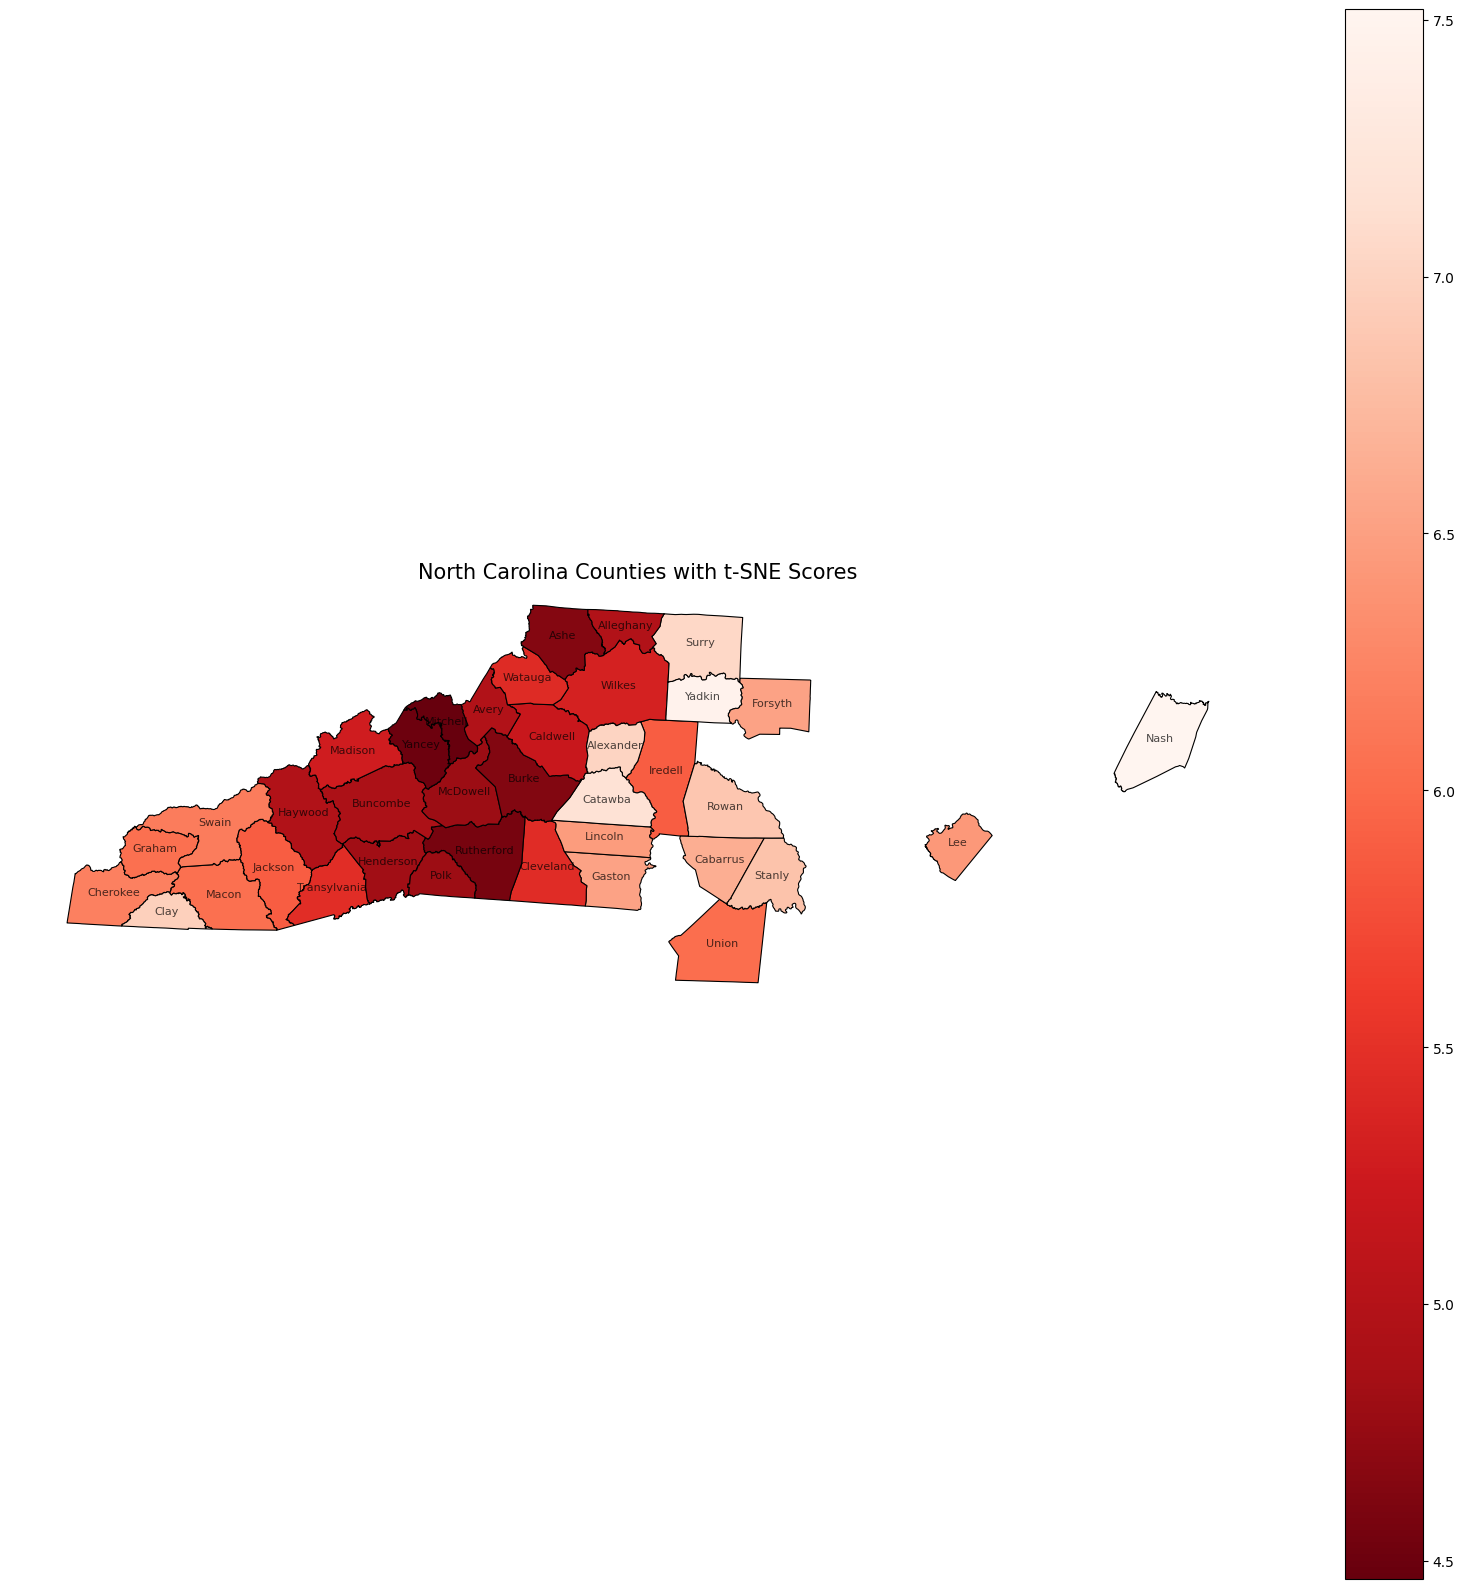

In [17]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE  # Import t-SNE

# t-SNE for 1D embedding
tsne_reducer = TSNE(n_components=1, random_state=42, perplexity=30, learning_rate='auto', init='random')
embedding_1d = tsne_reducer.fit_transform(normalized_values)

# Create a sorted table of counties by their 1D t-SNE embedding values
sorted_table = pd.DataFrame({
    'County': county_names,
    'tSNE_1D': embedding_1d.flatten()
}).sort_values(by='tSNE_1D').reset_index(drop=True)

print("Sorted Counties by 1D t-SNE Embedding:")
print(sorted_table)

# Load geographic data for NC counties
nc_counties = gpd.read_file("Boundaries/NCDOT_County_Boundaries.shp")
nc_counties['NAME'] = nc_counties['NAME'].str.strip()

# Merge cluster labels and t-SNE scores with geographic data
normalized_data['tSNE_1D'] = embedding_1d.flatten()
merged_data = nc_counties.merge(normalized_data, left_on='NAME', right_on='County')

# Determine Buncombe's t-SNE value
buncombe_tsne_value = merged_data.loc[merged_data['NAME'] == 'Buncombe', 'tSNE_1D'].values[0]

# Check whether to flip the colormap
cmap = 'Reds'
if buncombe_tsne_value < np.median(merged_data['tSNE_1D']):
    cmap = cmap + '_r'  # Reverse the colormap if Buncombe is below the median

# Plot counties colored by t-SNE score
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
merged_data.plot(
    column='tSNE_1D',
    cmap=cmap,
    linewidth=0.8,
    ax=ax,
    edgecolor='black',
    legend=True
)

# Add county labels without scores
for x, y, label in zip(merged_data.geometry.centroid.x, merged_data.geometry.centroid.y, merged_data['NAME']):
    ax.text(x, y, label, fontsize=8, ha='center', alpha=0.7)

ax.set_title("North Carolina Counties with t-SNE Scores", fontdict={'fontsize': '15', 'fontweight': '3'})
ax.axis('off')
plt.tight_layout()
plt.show()


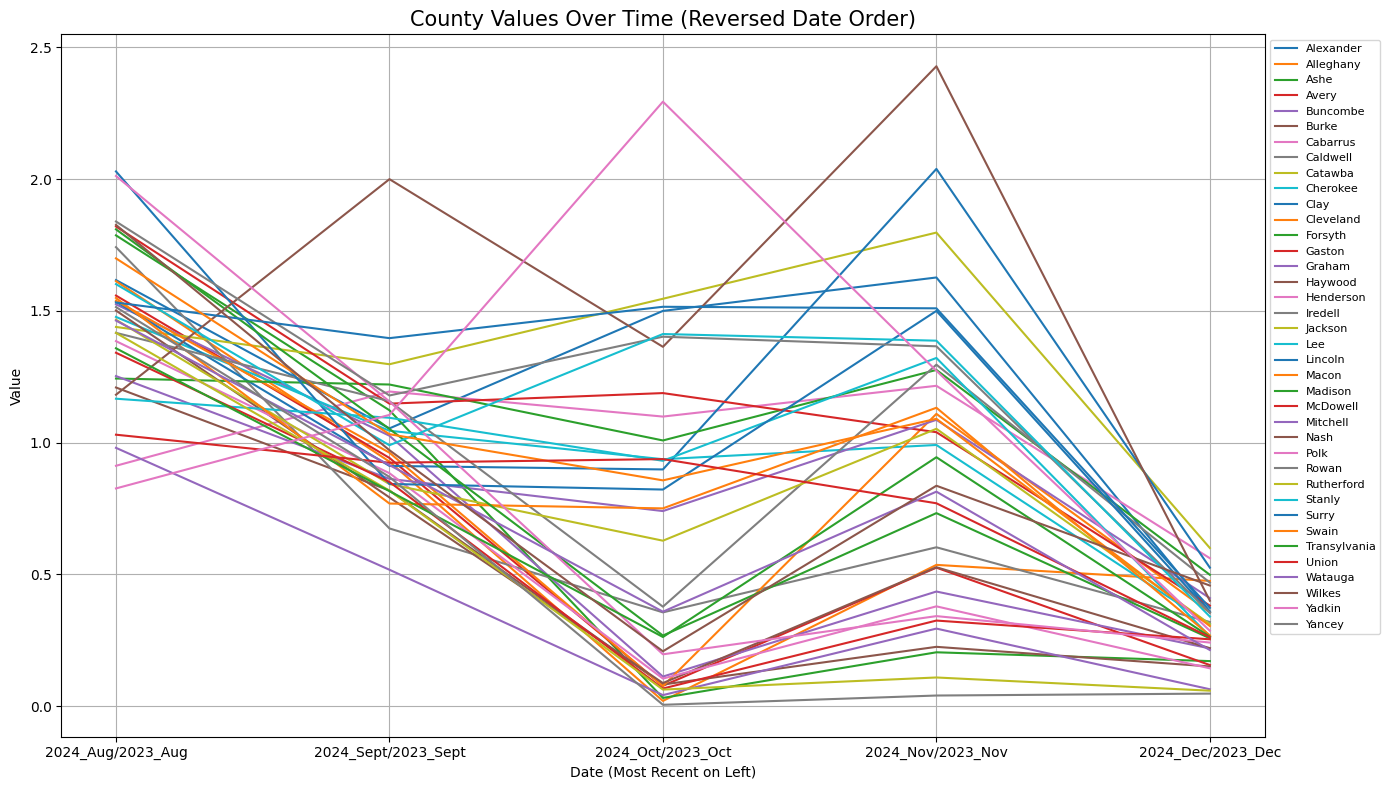

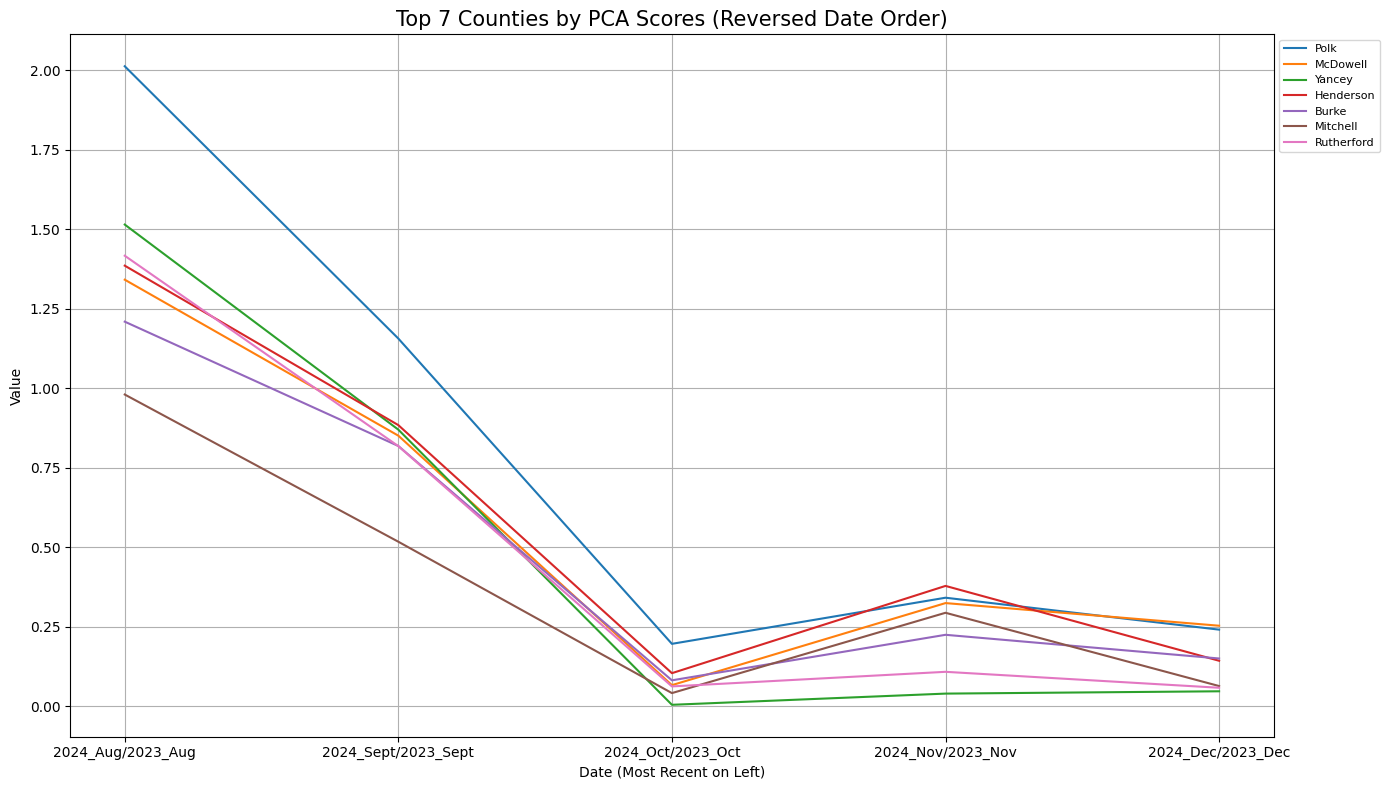

In [12]:
# Plot line chart of values over time for each county
date_columns = [col for col in normalized_data.columns if col.startswith("2022") or col.startswith("2023") or col.startswith("2024")]
plt.figure(figsize=(14, 8))
for county, row in normalized_data.iterrows():
    plt.plot(date_columns[::-1], row[date_columns].values[::-1], label=row['County'])

plt.title("County Values Over Time (Reversed Date Order)", fontsize=15)
plt.xlabel("Date (Most Recent on Left)")
plt.ylabel("Value")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot line chart for the 7 counties with the highest PCA scores
highest_pca = sorted_table.tail(7)
plt.figure(figsize=(14, 8))
for _, row in highest_pca.iterrows():
    county_data = normalized_data[normalized_data['County'] == row['County']]
    plt.plot(date_columns[::-1], county_data[date_columns].values.flatten()[::-1], label=row['County'])

plt.title("Top 7 Counties by PCA Scores (Reversed Date Order)", fontsize=15)
plt.xlabel("Date (Most Recent on Left)")
plt.ylabel("Value")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()



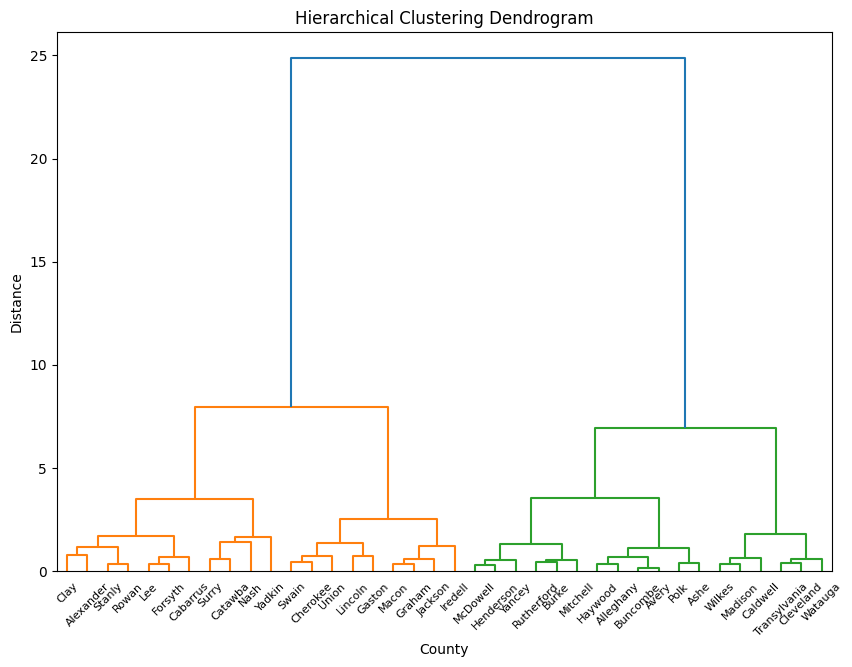

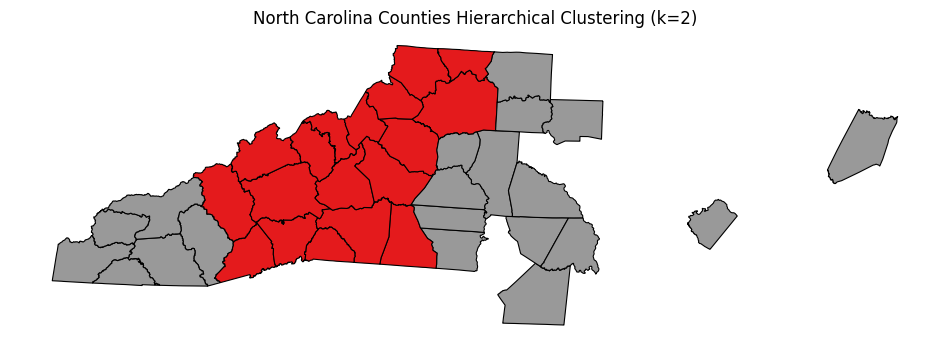

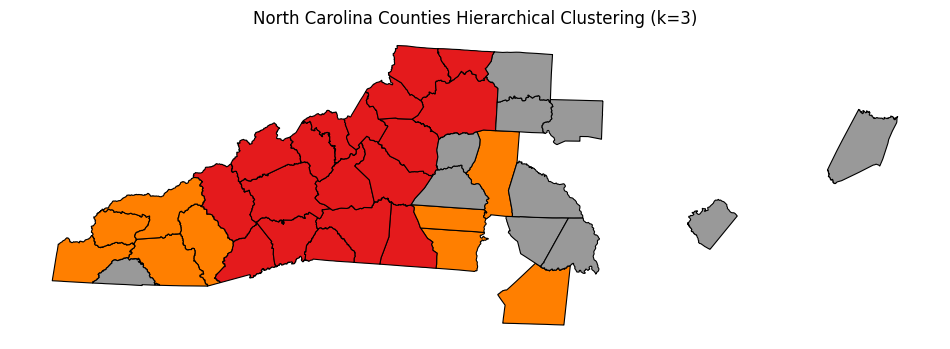

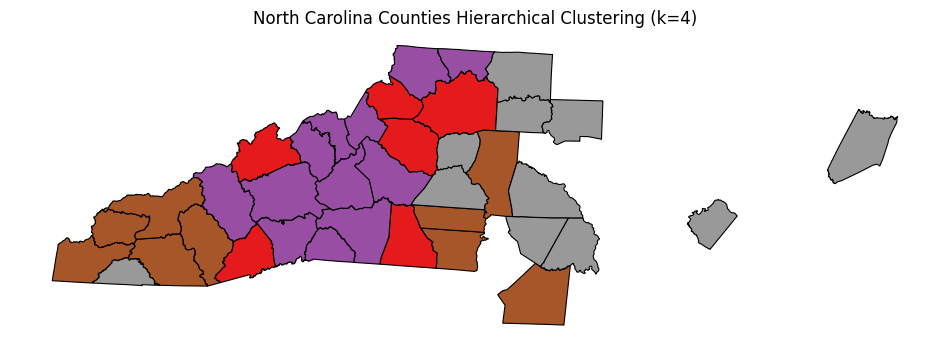

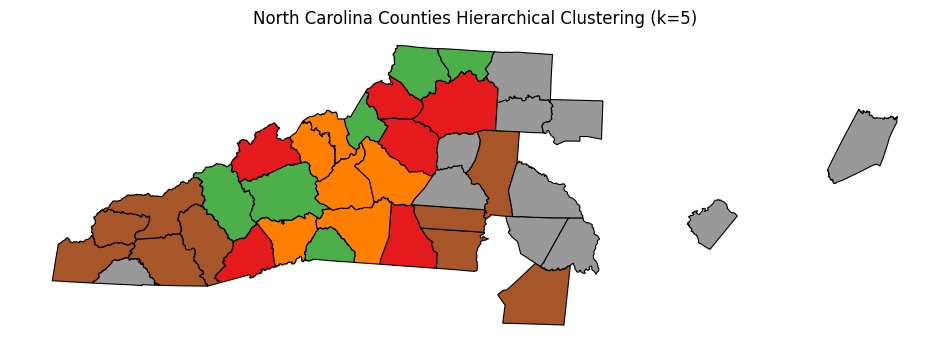

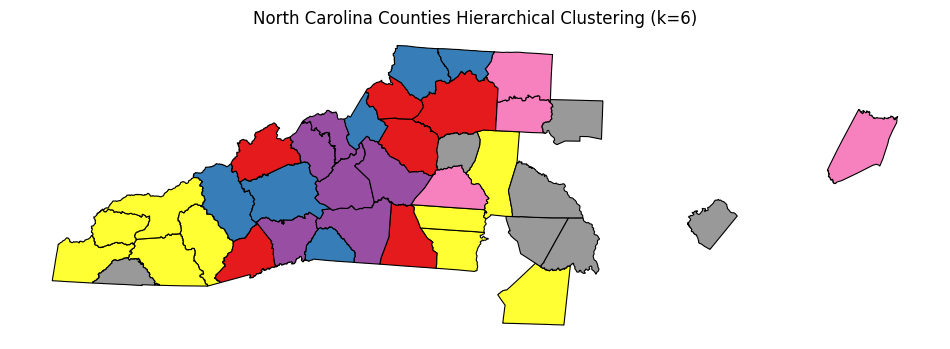

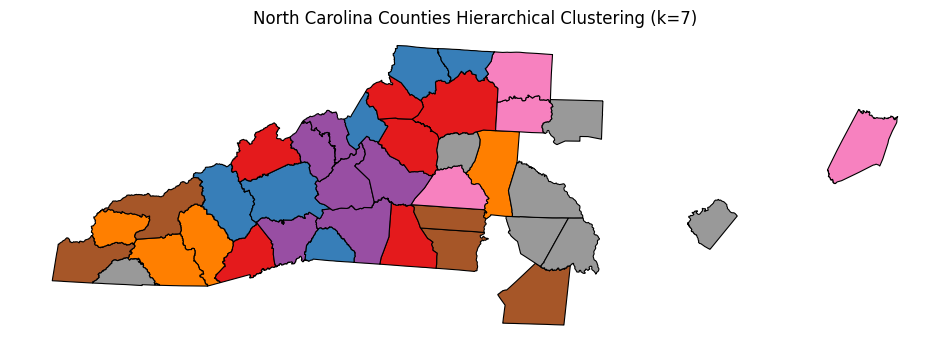

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt

# Prepare data
X = normalized_data.drop(columns=['County', 'Cluster']).values

# Perform hierarchical clustering
linked = linkage(X, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=normalized_data['County'].values, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('County')
plt.ylabel('Distance')
plt.show()

# Define hcluster function
def hcluster(num_clusters, normalized_data, linked, merged_geo_original):
    hierarchical_clusters = fcluster(linked, num_clusters, criterion='maxclust')
    normalized_data['Hierarchical_Cluster'] = hierarchical_clusters

    # Make a copy of merged_geo to avoid overwriting it
    merged_geo = merged_geo_original.copy()
    merged_geo = merged_geo.merge(normalized_data[['County', 'Hierarchical_Cluster']], on='County', how='left')

    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    merged_geo.plot(
        column='Hierarchical_Cluster',
        cmap='Set1',
        linewidth=0.8,
        ax=ax,
        edgecolor='black'
    )
    plt.title(f"North Carolina Counties Hierarchical Clustering (k={num_clusters})")
    plt.axis('off')
    plt.show()

# Example usage
merged_geo = nc_counties.merge(normalized_data, left_on='NAME', right_on='County')
hcluster(2, normalized_data.copy(), linked, merged_geo)
hcluster(3, normalized_data.copy(), linked, merged_geo)
hcluster(4, normalized_data.copy(), linked, merged_geo)
hcluster(5, normalized_data.copy(), linked, merged_geo)
hcluster(6, normalized_data.copy(), linked, merged_geo)
hcluster(7, normalized_data.copy(), linked, merged_geo)


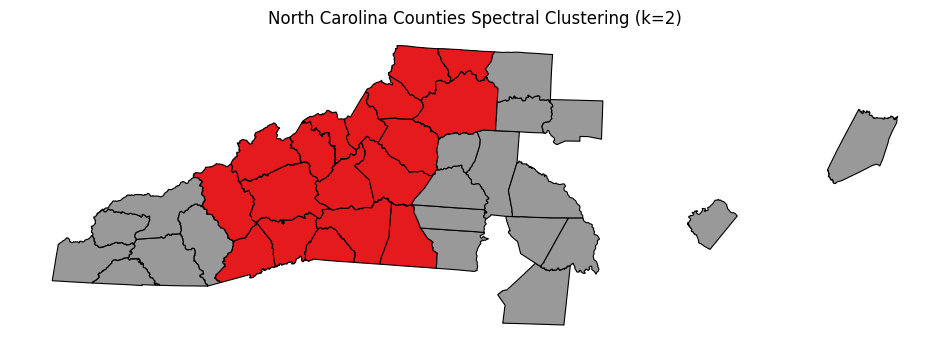

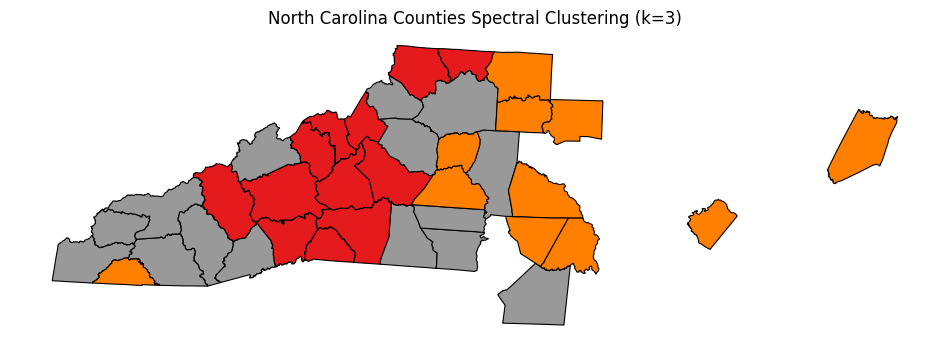

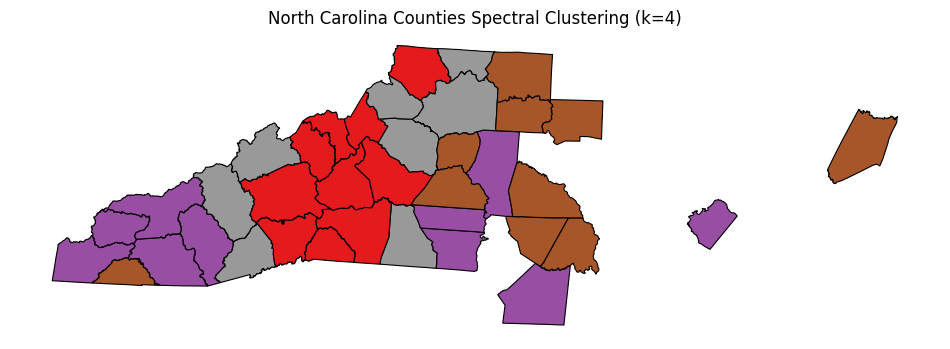

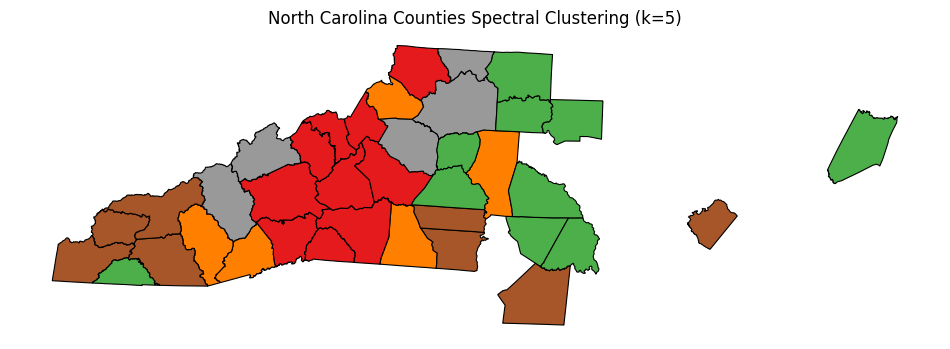

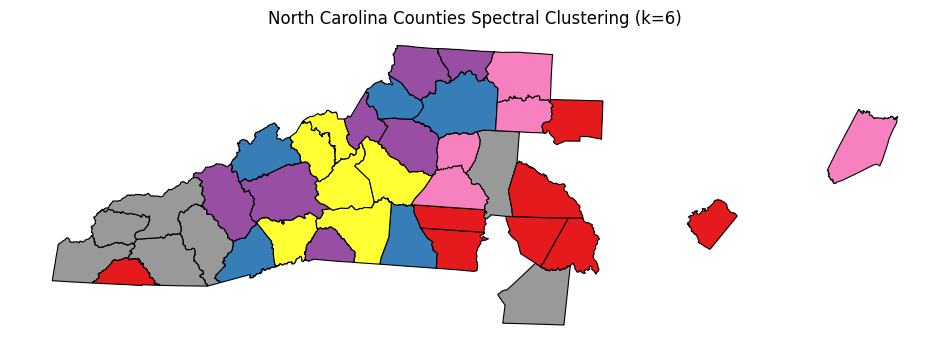

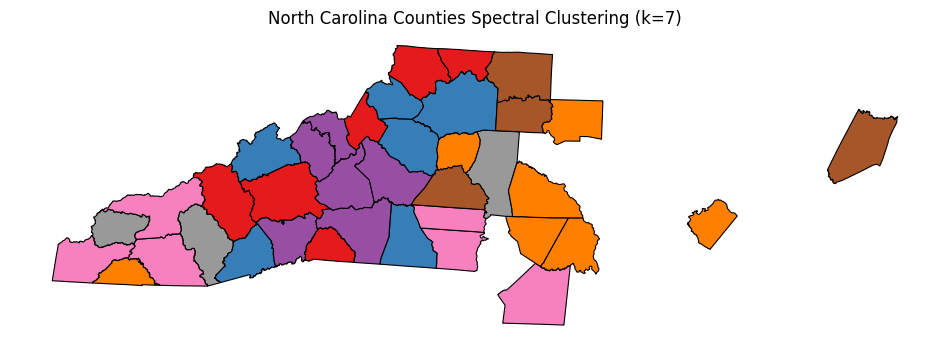

In [14]:
from sklearn.cluster import SpectralClustering
from matplotlib import pyplot as plt

# Define spectral clustering function
def spectral_cluster(num_clusters, normalized_data, merged_geo_original):
    # Perform spectral clustering
    spectral = SpectralClustering(
        n_clusters=num_clusters,
        affinity='nearest_neighbors',
        n_neighbors=10,  # Choose based on your dataset size
        random_state=42
    )
    spectral_clusters = spectral.fit_predict(normalized_data.drop(columns=['County', 'Cluster']).values)
    
    # Add cluster assignments to normalized_data
    normalized_data['Spectral_Cluster'] = spectral_clusters + 1  # +1 to match 1-based indexing for clusters

    # Make a copy of merged_geo to avoid overwriting it
    merged_geo = merged_geo_original.copy()
    merged_geo = merged_geo.merge(normalized_data[['County', 'Spectral_Cluster']], on='County', how='left')

    # Plot the clustering result on the map
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    merged_geo.plot(
        column='Spectral_Cluster',
        cmap='Set1',
        linewidth=0.8,
        ax=ax,
        edgecolor='black'
    )
    plt.title(f"North Carolina Counties Spectral Clustering (k={num_clusters})")
    plt.axis('off')
    plt.show()

# Example usage
spectral_cluster(2, normalized_data.copy(), merged_geo.copy())
spectral_cluster(3, normalized_data.copy(), merged_geo.copy())
spectral_cluster(4, normalized_data.copy(), merged_geo.copy())
spectral_cluster(5, normalized_data.copy(), merged_geo.copy())
spectral_cluster(6, normalized_data.copy(), merged_geo.copy())
spectral_cluster(7, normalized_data.copy(), merged_geo.copy())


In [40]:

# Step 2: Define excluded counties and create included/excluded DataFrames
excluded_counties = {'Swain', 'Macon', 'Jackson', 'Haywood', 'Transylvania', 'Madison', 'Buncombe', 'Henderson', 'Yancey', 'Mitchell', 'McDowell', 'Polk', 'Rutherford', 'Avery', 'Burke', 'Cleveland', 'Watauga', 'Caldwell', 'Catawba', 'Lincoln', 'Gaston', 'Ashe', 'Alleghany', 'Wilkes', 'Alexander', 'Catawba', 'Surry', 'Yadkin', 'Union'}
import pandas as pd

# Step 1: Read the CSV file
file_path = 'Data/transposed_data.csv'
df = pd.read_csv(file_path)

# Ensure that 'County' is treated as a string
df['County'] = df['County'].astype(str)


# Create masks for included and excluded counties
included_mask = ~df['County'].isin(excluded_counties)
excluded_mask = df['County'].isin(excluded_counties)

included_df = df[included_mask].copy()
excluded_df = df[excluded_mask].copy()

# Step 3: Sum visitations for included counties per month
# Extract month columns (assuming they are all columns except 'County')
month_columns = [col for col in df.columns if col != 'County']

# Sum included counties per month
included_sum = included_df[month_columns].sum()

# Step 4: Compute the ratio of 2024_month_i / 2023_month_i for each month
# Extract 2024 and 2023 month columns
months_2024 = [f'2024-{str(m).zfill(2)}' for m in range(1, 13)]
months_2023 = [f'2023-{str(m).zfill(2)}' for m in range(1, 13)]

# Verify all required columns are present
missing_months_2024 = set(months_2024) - set(month_columns)
missing_months_2023 = set(months_2023) - set(month_columns)

if missing_months_2024 or missing_months_2023:
    raise ValueError(f"Missing month columns: {missing_months_2024.union(missing_months_2023)}")

# Calculate ratios
ratios = included_sum[months_2024].values / included_sum[months_2023].values
ratios_series = pd.Series(ratios, index=[f'{m:02}' for m in range(1, 13)])

print("Ratios of 2024 to 2023 visitations for included counties per month:")
print(ratios_series)
print("\n")

# Step 5: Estimate 2024 visitations for excluded counties without the hurricane
# For each excluded county and each month:
# Estimated_2024 = Excluded_2023 * ratio
# Impact_ratio = Actual_2024 / Estimated_2024

# Extract 2024 and 2023 data for excluded counties
excluded_2024 = excluded_df[months_2024].copy()
excluded_2023 = excluded_df[months_2023].copy()

# Rename columns to just month numbers for ease of handling
excluded_2024.columns = [f'{m:02}' for m in range(1, 13)]
excluded_2023.columns = [f'{m:02}' for m in range(1, 13)]

# Step 5a: Calculate Estimated 2024 visitations without hurricane
estimated_2024 = excluded_2023.multiply(ratios_series, axis=1)

# Step 6: Calculate Impact Ratios
impact_ratios = excluded_2024.divide(estimated_2024)

# Handle division by zero or NaN values by replacing them with NaN
impact_ratios.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# Add County names back to the DataFrame
impact_ratios.insert(0, 'County', excluded_df['County'])

# Step 7: Display the results per affected county
selected_months = ['10', '11']
impact_ratios_filtered = impact_ratios[['County'] + [f'{m}' for m in selected_months]]

# Step 8: Display the filtered results per affected county
print("Impact of Hurricane on Excluded Counties for October, November, December (Actual 2024 / Estimated 2024):")
print(impact_ratios_filtered)

# Optionally, save the filtered results to a new CSV file
impact_ratios_filtered.to_csv('Data/hurricane_impact_results.csv', index=False)
print("\nFiltered results have been saved to 'Data/hurricane_impact_result.csv'.")

Ratios of 2024 to 2023 visitations for included counties per month:
01    1.039834
02    1.496821
03    1.507618
04    1.473333
05    1.110982
06    1.339231
07    1.070665
08    1.316537
09    1.092268
10    0.925880
11    1.271981
12    0.423339
dtype: float64


Impact of Hurricane on Excluded Counties for October, November, December (Actual 2024 / Estimated 2024):
          County        10        11
0      Alexander  1.620080  1.279001
1      Alleghany  0.021178  0.421349
2           Ashe  0.033490  0.160528
3          Avery  0.083106  0.413065
4       Buncombe  0.120941  0.341825
5          Burke  0.088337  0.176804
7       Caldwell  0.384180  0.473859
8        Catawba  1.669843  1.412990
11     Cleveland  0.081747  0.871958
13        Gaston  1.283140  0.817267
15       Haywood  0.094330  0.414336
16     Henderson  0.112669  0.297614
18       Jackson  0.678000  0.827441
20       Lincoln  0.887715  1.179263
21         Macon  0.810482  0.890251
22       Madison  0.289148  0.575815
2

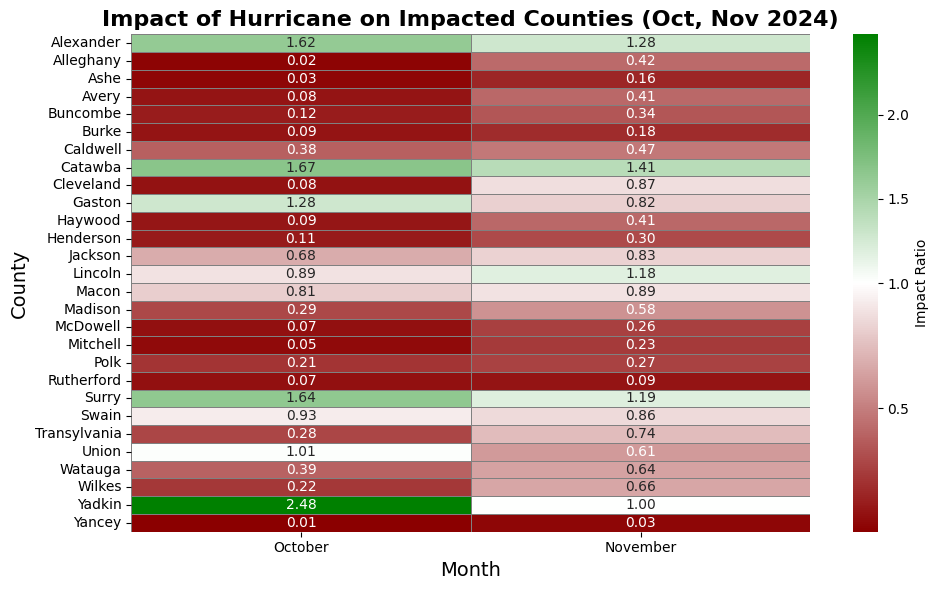

In [41]:
# Step 8: Create a Heatmap for the Impact Ratios of October, November, December
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# Prepare data for the heatmap
# Set 'County' as the index for better visualization
heatmap_data = impact_ratios_filtered.set_index('County')

# Convert the DataFrame to float (if not already)
heatmap_data = heatmap_data.astype(float)

# Define the custom color map: Blood Red at 0, White at 1, Green above 1
# Colors:
# 0 -> Blood Red (#8B0000)
# 1 -> White (#FFFFFF)
# >1 -> Green (#008000)

# Create a custom diverging color map
custom_cmap = LinearSegmentedColormap.from_list('RedWhiteGreen', ['#8B0000', '#FFFFFF', '#008000'])

# Define normalization with a center at 1
norm = TwoSlopeNorm(vmin=heatmap_data.min().min(),
                   vcenter=1,
                   vmax=heatmap_data.max().max())

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the heatmap
sns.heatmap(
    heatmap_data,
    annot=True,                     # Show the impact ratio values in the cells
    fmt=".2f",                      # Format the annotation to two decimal places
    cmap=custom_cmap,              # Custom color map
    norm=norm,                      # Normalization centered at 1
    linewidths=.5,                  # Add lines between cells
    linecolor='gray',               # Color of the lines
    cbar_kws={'label': 'Impact Ratio'}  # Label for the color bar
)

# Customize the plot
plt.title('Impact of Hurricane on Impacted Counties (Oct, Nov 2024)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('County', fontsize=14)
plt.xticks(ticks=[0.5, 1.5], labels=['October', 'November'], rotation=0)
plt.yticks(rotation=0)

# Adjust layout for better fit
plt.tight_layout()

# Display the heatmap
plt.show()


Successfully read shapefile.
North Carolina Counties Shapefile:
   OBJECTID  FIPS CountyName UpperCount SapCountyI  DOTDistric  DOTDivisio  \
0         1    29     Camden     CAMDEN        015           1           1   
1         2    73      Gates      GATES        037           1           1   
2         3    97    Iredell    IREDELL        049           2          12   
3         4   193     Wilkes     WILKES        097           3          11   
4         5   179      Union      UNION        090           3          10   

   SAP_CNTY_N  CNTY_NBR  DSTRCT_NBR  DIV_NBR     NAME  SHPNumber  \
0          15        14           1        1   Camden         15   
1          37        36           1        1    Gates         37   
2          49        48           2       12  Iredell         49   
3          97        96           3       11   Wilkes         97   
4          90        89           3       10    Union         90   

     ShapeSTAre     ShapeSTLen  \
0  8.650426e+09  680450.

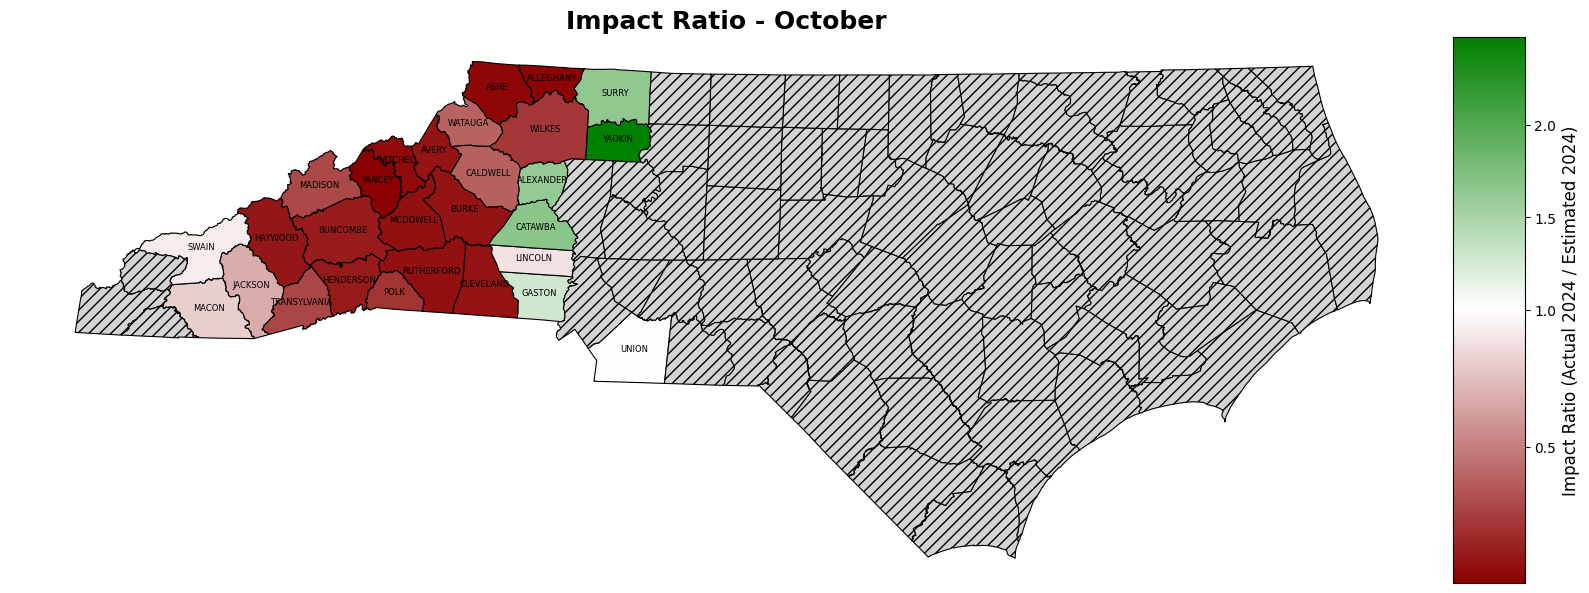

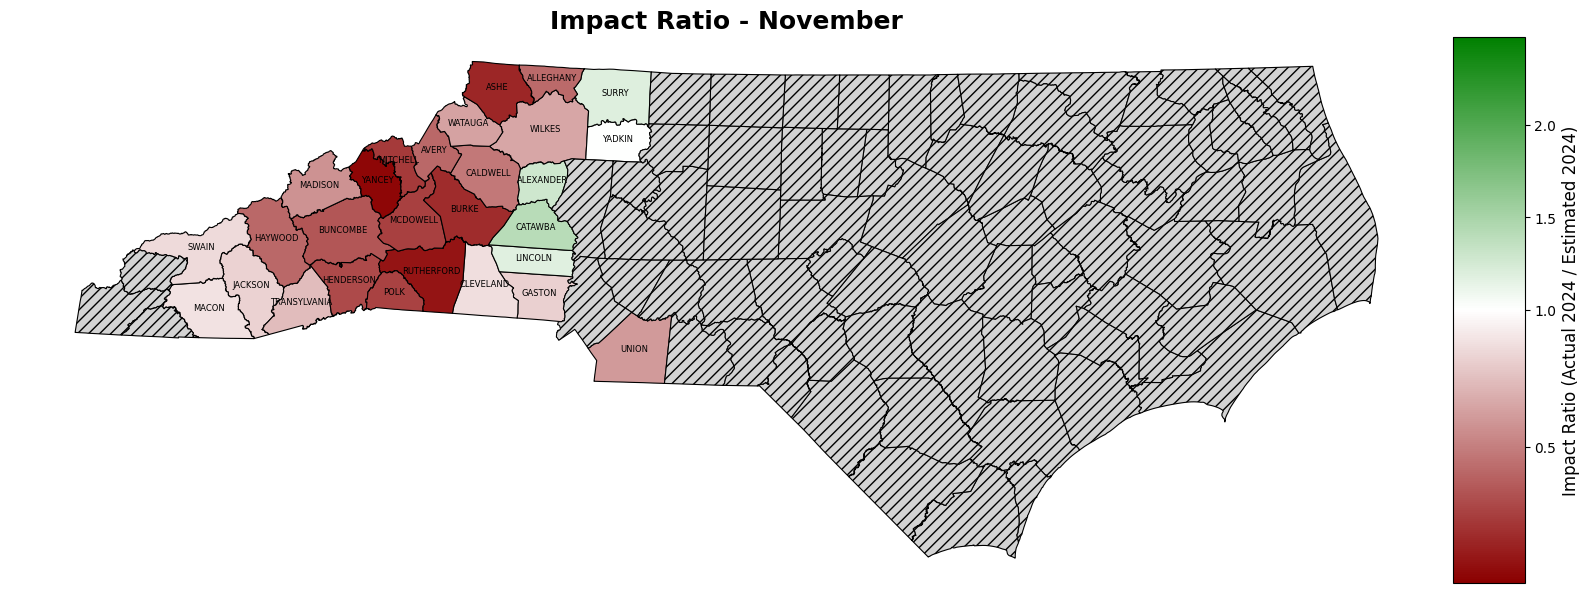

In [42]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# Step 2: Read the Shapefile
# ---------------------------

# Path to the shapefile
shapefile_path = 'Boundaries/NCDOT_County_Boundaries.shp'

# Read the shapefile into a GeoDataFrame
try:
    nc_counties = gpd.read_file(shapefile_path)
    print("Successfully read shapefile.")
except FileNotFoundError:
    print(f"Error: The shapefile '{shapefile_path}' was not found.")
    exit(1)
except Exception as e:
    print(f"Error reading shapefile: {e}")
    exit(1)

# Check the first few rows
print("North Carolina Counties Shapefile:")
print(nc_counties.head())
print("\n")

# ---------------------------
# Step 3: Prepare the Shapefile Data
# ---------------------------

# Ensure consistent county name casing for merging
nc_counties['NAME'] = nc_counties['NAME'].str.strip().str.upper()
impact_ratios['County'] = impact_ratios['County'].str.strip().str.upper()

# Calculate centroids for labeling
nc_counties['centroid'] = nc_counties.geometry.centroid

# ---------------------------
# Step 5: Merge Impact Ratios with Shapefile
# ---------------------------

# Perform the merge
nc_merged = nc_counties.merge(impact_ratios, left_on='NAME', right_on='County', how='left')

# Verify the merge
print("Merged GeoDataFrame:")
print(nc_merged.head())
print("\n")

# ---------------------------
# Step 7: Define the Custom Color Map
# ---------------------------

# Define the custom diverging color map
custom_cmap = LinearSegmentedColormap.from_list('RedWhiteGreen', ['#8B0000', '#FFFFFF', '#008000'])

# Define normalization centered at 1
min_ratio = nc_merged[['10', '11']].min().min()
max_ratio = nc_merged[['10', '11']].max().max()

norm = TwoSlopeNorm(vmin=min_ratio if min_ratio < 1 else 1,
                   vcenter=1,
                   vmax=max_ratio if max_ratio > 1 else 1)

# ---------------------------
# Step 8: Plot the Heatmaps on the Map
# ---------------------------

# Define the months to plot
selected_months = ['10', '11']
month_names = {'10': 'October', '11': 'November'}

for month in selected_months:
    month_col = f'{month}'

    # Initialize the figure
    fig, ax = plt.subplots(figsize=(16, 12))

    # Plot the counties with the impact ratio
    nc_merged.plot(
        column=month_col,
        cmap=custom_cmap,
        linewidth=0.8,
        ax=ax,
        edgecolor='black',
        norm=norm,
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "black",
            "hatch": "///",
            "label": "No Data"
        }
    )

    # Add county names as annotations (only for counties with data)
    for idx, row in nc_merged.iterrows():
        if pd.notnull(row[month_col]):
            ax.annotate(
                text=row['NAME'],
                xy=(row['centroid'].x, row['centroid'].y),
                fontsize=6,
                ha='center',
                color='black'
            )

    # Set the title
    ax.set_title(f'Impact Ratio - {month_names[month]}', fontdict={'fontsize': '18', 'fontweight': 'bold'})

    # Remove axis
    ax.axis('off')

    # Add a colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm._A = []  # Dummy array for the ScalarMappable
    cbar = fig.colorbar(sm, cax=cax)
    cbar.set_label('Impact Ratio (Actual 2024 / Estimated 2024)', fontsize=12)

    # Save or show the plot
    plt.tight_layout()
    plt.show()


In [50]:
import geopandas as gpd
from esda import Moran
from libpysal.weights import Queen
# Moran's I is a measure of spatial autocorrelation, indicating whether similar values occur near each other geographically.
# Value of 0.4928: Indicates moderate to strong positive spatial autocorrelation. This suggests that counties with similar values (e.g., visitation rates) tend to be geographically clustered.

# Assuming 'merged_data' contains your geospatial and normalized data
w = Queen.from_dataframe(merged_data)
w.transform = 'r'

# Calculate Moran's I for a specific variable, e.g., 'PCA_1D'
moran = Moran(merged_data['PCA_1D'], w)
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")



('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 25, ' is an island (no neighbors)')
Moran's I: 0.4928018547133672, p-value: 0.001
